# Predicting Palmera Chocolate

We are going now to examine and treat our first series: palmera de chocolate.
    
Along this script we will:
    
1) Paint the series, examine its autocorrelations and seasonality and get some useful insights.

2) Apply different kinds of models to it, particularly time series models and machine learning models, also, neuronal networks will be considered.

3) Check the results we get from each method and extract our conclusions

# 0) Index

<a href='#a1'>1) Introductory examination</a>

<a href='#a11'>1.1) Series plot and first values</a>

<a href='#a12'>1.2) Stationarity test: augmented Dickey-Fuller</a>

<a href='#a13'>1.3) Monthly averages and yearly seasonality</a>

<a href='#a14'>1.4) Autocorrelation, ACF and PACF</a>

<a href='#a15'>1.5) Series decomposition</a>

<a href='#a2'>2) Models application</a>

<a href='#a20'>2.0) Split Train-Test, selecting the metric for our errors and setting benchmarks</a>

<a href='#a21'>2.1) TIME SERIES METHODS</a>

<a href='#a211'>2.1.1) EXPONENTIAL MODELS</a>

<a href='#a212'>2.1.2) ARIMA</a>

<a href='#a213'>2.1.3) SARIMA</a>

<a href='#a214'>2.1.4) PROPHET</a>

<a href='#a22'>2.2.) MACHINE LEARNING: RANDOM FOREST</a>

<a href='#a3'>3) Model selection</a>

<a href='#a4'>4) Conclusions</a>

# 1) Introductory examination<a id='a1'></a>

We import the required packages and our dataframe, and extract from it our series.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# importing tools from statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.tsa as tsa
from statsmodels.tsa import seasonal
from statsmodels.tsa import stattools as stto

from datetime import timedelta

plt.style.use('ggplot')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# train-test split library
from sklearn.model_selection import train_test_split

import random

# ERRORS
from sklearn.metrics import mean_squared_error
from fbprophet.diagnostics import performance_metrics


# EXPONENTIAL SMOOTHING
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# CHECKS
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

# ARIMA
from statsmodels.tsa.arima_model import ARIMA

# SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

# RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor

#PROPHET
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 5

In [3]:
sep=";"
exit_path = "../../data/03_processed/" + "time_series.csv"

In [4]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

In [5]:
df=pd.read_csv(exit_path, sep=sep, parse_dates=True, index_col='order_date')

In [6]:
palmera_choco=df[df['product']=='palmera chocolate'][['units_ordered','festivo','weight']]

Now, we check our series, by plotting it and getting its first statistical values:

### 1.1) Series plot and first values<a id='a11'></a>

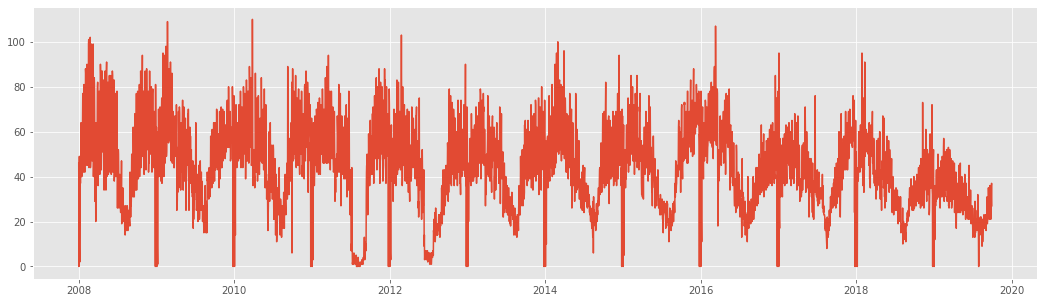

In [7]:
plt.plot(palmera_choco['units_ordered'])

#Important note: due to a bug in prophet series.plot() does not work

In [8]:
palmera_choco['units_ordered'].describe()

count    4291.000000
mean       43.670007
std        18.076184
min         0.000000
25%        32.000000
50%        43.000000
75%        55.000000
max       110.000000
Name: units_ordered, dtype: float64

As we can see, the series is possibly stationary: it has (at first glance) no trend, and no changes in variance.
    
We can also see that its mean value is about 43, and that there is no much difference between its mean and its median value, what is a good sign for the skewness.

We can also see that the series has a great dispersion in its daily values.

In order to smooth it and get some other insights, let's get and plot the series for the monthly average data.

### 1.2) Stationarity test: augmented Dickey-Fuller<a id='a12'></a>

We are now going to check wether our series has any root bigger than 1 or it does not, in order to check its stationarity.

In a time series, if the process's characteristic equation presents a root with a value greater than 1, then the process will be non stationary.

So, in order to get stationarity for a determined process, all its roots of the characteristic equation must lie inside the unit circle—that is, have a modulus (absolute value) of less than one.

This is tested using the augmented Dickey-Fuller test.

The augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey–Fuller test for a larger and more complicated set of time series models.

The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

In [9]:
adf_test_results = adfuller(palmera_choco['units_ordered'])

print("p-value: ", adf_test_results[1])
print("test value:", adf_test_results[0])
print("% confidence p-values: ", adf_test_results[4])

p-value:  4.860621460902781e-07
test value: -5.791487673614479
% confidence p-values:  {'1%': -3.43188633380603, '5%': -2.8622188674189872, '10%': -2.5671313664110107}


As we can see, the p value is about 0. Also, comparing the test value with the p-values for the 1% p-value (-5.79 to -3.43) we can see that we can clearly state that our series is stationary or trend-stationary.

### 1.3) Monthly averages and yearly seasonality<a id='a13'></a>

We are going to aggregate the data by month, stabiblishing their means, to check for the appearance of any patterns:

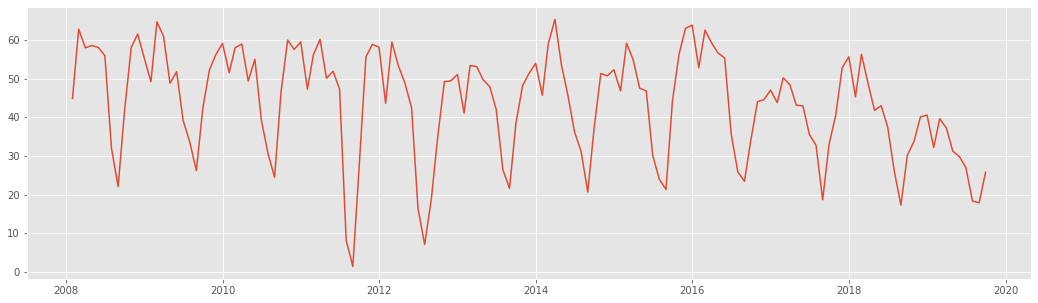

In [10]:
monthly  = palmera_choco.reset_index().groupby(pd.Grouper(key='order_date', freq='M'))['units_ordered'].mean()
plt.plot(monthly)
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as there is always a bump in orders during the middle the year.

We can see also that the series lacks a clear trend.

We also can see that the series presents minimums once a year, being more pronounced at 2011 and 2012.

We aree going to plot a couple of years to check where these minimums occur.

In [11]:
monthly.reset_index().head()

,order_date,units_ordered
0,2008-01-31,44.870968
1,2008-02-29,62.758621
2,2008-03-31,57.935484
3,2008-04-30,58.533333
4,2008-05-31,58.000000


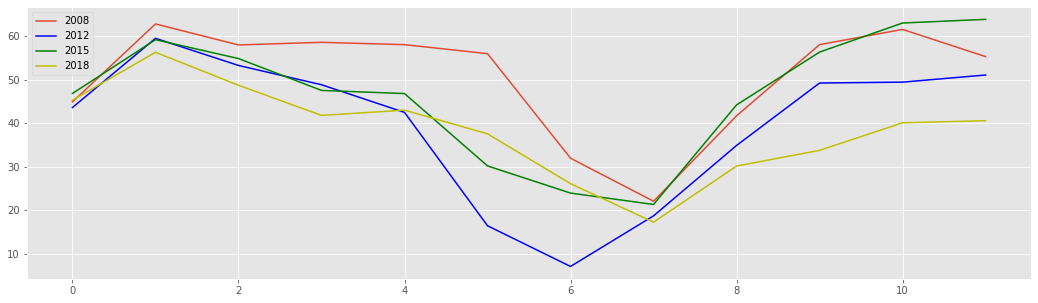

In [12]:
plt.plot(monthly['2008'].reset_index()['units_ordered'])
plt.plot(monthly['2012'].reset_index()['units_ordered'], color='b')
plt.plot(monthly['2015'].reset_index()['units_ordered'], color='g')
plt.plot(monthly['2018'].reset_index()['units_ordered'], color='y')
plt.legend(['2008','2012','2015','2018'])
plt.show()

As we can see, for 3 out of the 4 values plotted, the mininum value is found in the month of August.

For the fourth series, the minimum appears at July.

Maximums appear in January for all series.

We have found that there is a clear yearly seasonality in our series.

Talking about seasonality, we are going to check now for autocorrelations, and we will use the information that we have extracted for our graphs above to use it in our favor when looking for such autocorrelations.

### 1.4) Autocorrelation, ACF and PACF<a id='a14'></a>

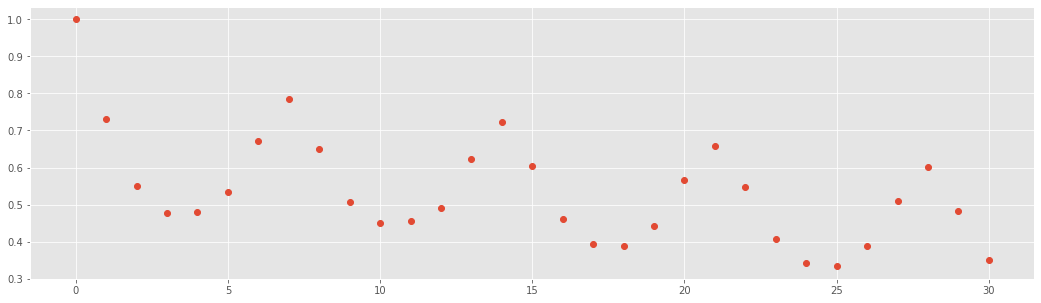

In [13]:
p_choc_acf=stto.acf(palmera_choco['units_ordered'], nlags=30)

plt.plot(p_choc_acf, 'o')

We check the plot with the plot_acf function that statsmodels also provides us, and that includes a visual p-value: a range(that can be seen below, red-shaded region) where values could be due to chance, up to a certain confidence level (or, to be more precise, a region of values that cannot be discarded as being being produced by chance):

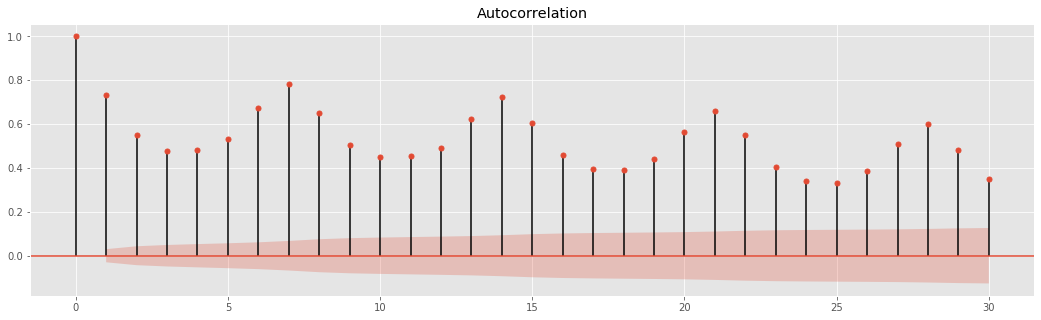

In [14]:
plot_acf(palmera_choco['units_ordered'], lags=30);

As we can see, our series presents both a strong relationship with its n-1 lag (correlation of about 0.75, and also a clear weekly autocorrelation (of about 0.8 - 0.75^6 ≈ 0.6).

As we know, if our process follows an AR(x) model, the value n will have a relation to value n-x of value alpha, then will present a correlation with the value n-2\*x of alpha^2, and a correlation of alpha^3 with the value n-3\*x and so on.

Also, appart from the stated, we cannot discard any of the correlations with the values up to the 7th.

Now, as we saw previously that a strong yearly seasonality existed, we are going now to check for autocorrelations in a more ample spectrum:

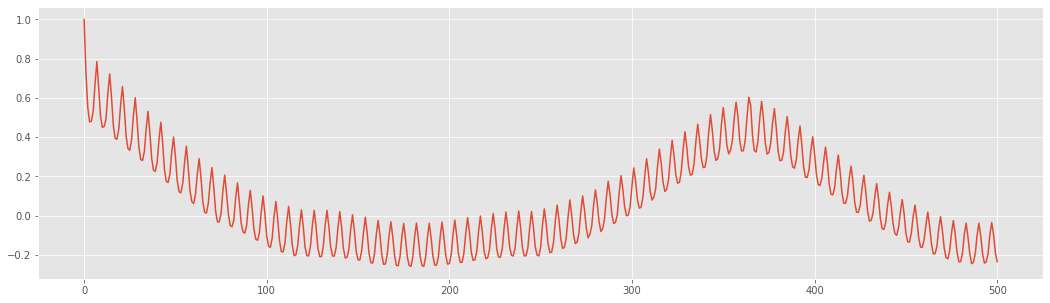

In [15]:
p_choc_acf=stto.acf(palmera_choco['units_ordered'], nlags=500)

plt.plot(p_choc_acf)

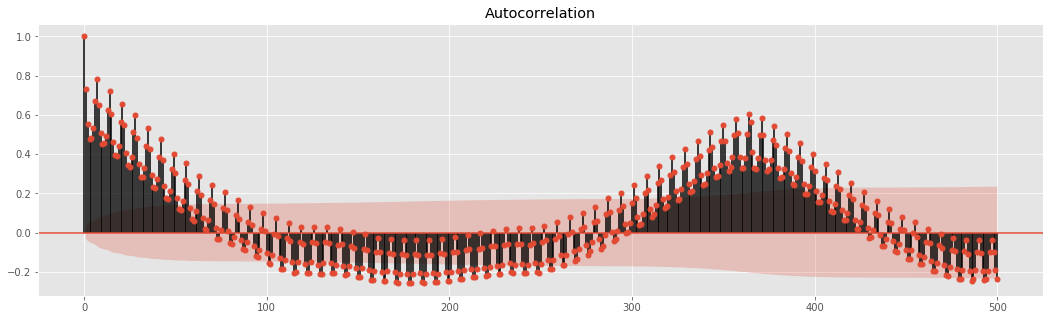

In [16]:
plot_acf(palmera_choco['units_ordered'], lags=500);

As we can see, there is a sinusoidal behaviour, and that the series presents a peak at lag 365.

We are checking that using our average monthly data, so we can get rid off the strong autocorrelations found in our daily series.

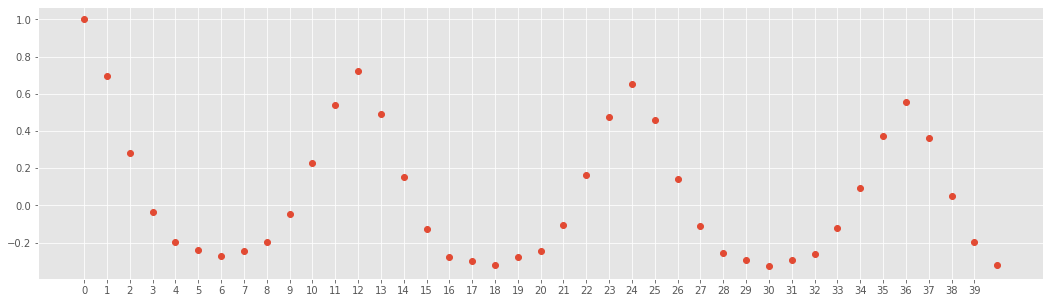

In [17]:
p_choc_acf=stto.acf(monthly, nlags=40)

plt.plot(p_choc_acf,  'o')
plt.xticks(list(range(40)));

We find a strong relationship involving each month with the same month of the previous year, showing, again, the yearly seasonality that we found during section 1.2.

Finally, we are checking the partial autocorrelation function, that shows us how much residual information is explained by adding a new lag.

PACF, instead of finding correlations of present with lags like ACF, finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. 

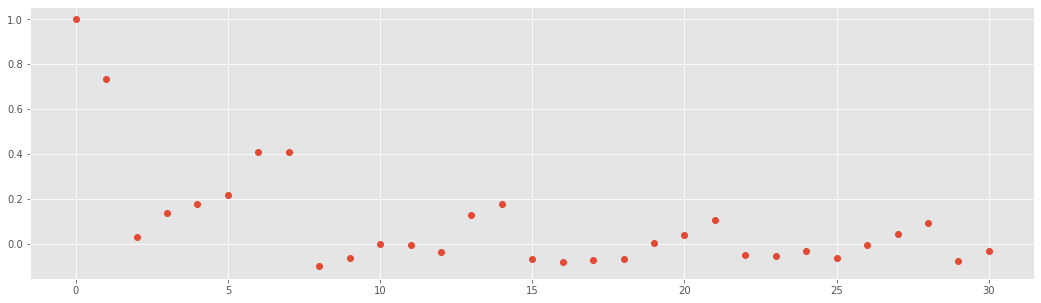

In [18]:
p_choc_acf=stto.pacf(palmera_choco['units_ordered'], nlags=30)

plt.plot(p_choc_acf, 'o')

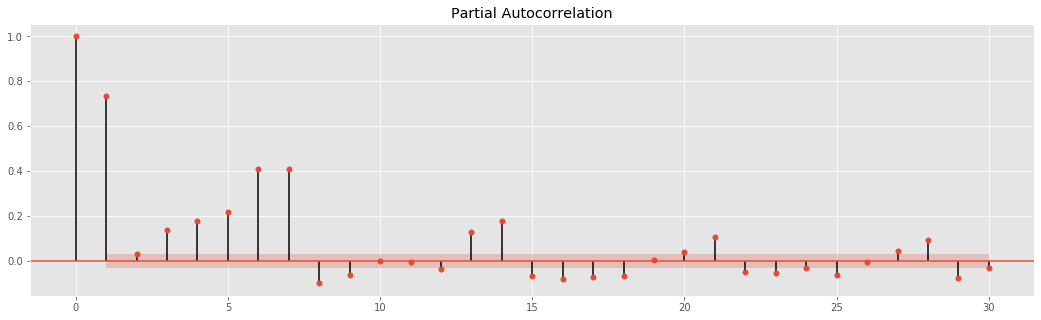

In [19]:
plot_pacf(palmera_choco['units_ordered'], lags=30);

The PACF confirms us what we saw in the acf: the series presents a strong correlation with its first lag (being most of the rest of the spikes merely the result of the propagation of the autocorrelation at lag 1), but there is also a strong autocorrelation with lags 6 and 7. So, in general, autoregressive models of order 7 will be needed to explain the series.

### 1.5) Series decomposition<a id='a15'></a>

Finally, to get a better grip on our series before studying it by any methods, we are going now to decompose the series using the seasonal_decompose tool provided in the statsmodel package.

This method uses moving averages to detrend the series and extract the seasonality.

It will give us another first impression on what we can expect about its behaviour, and also what methods should be in order for its analysis and forescasting.

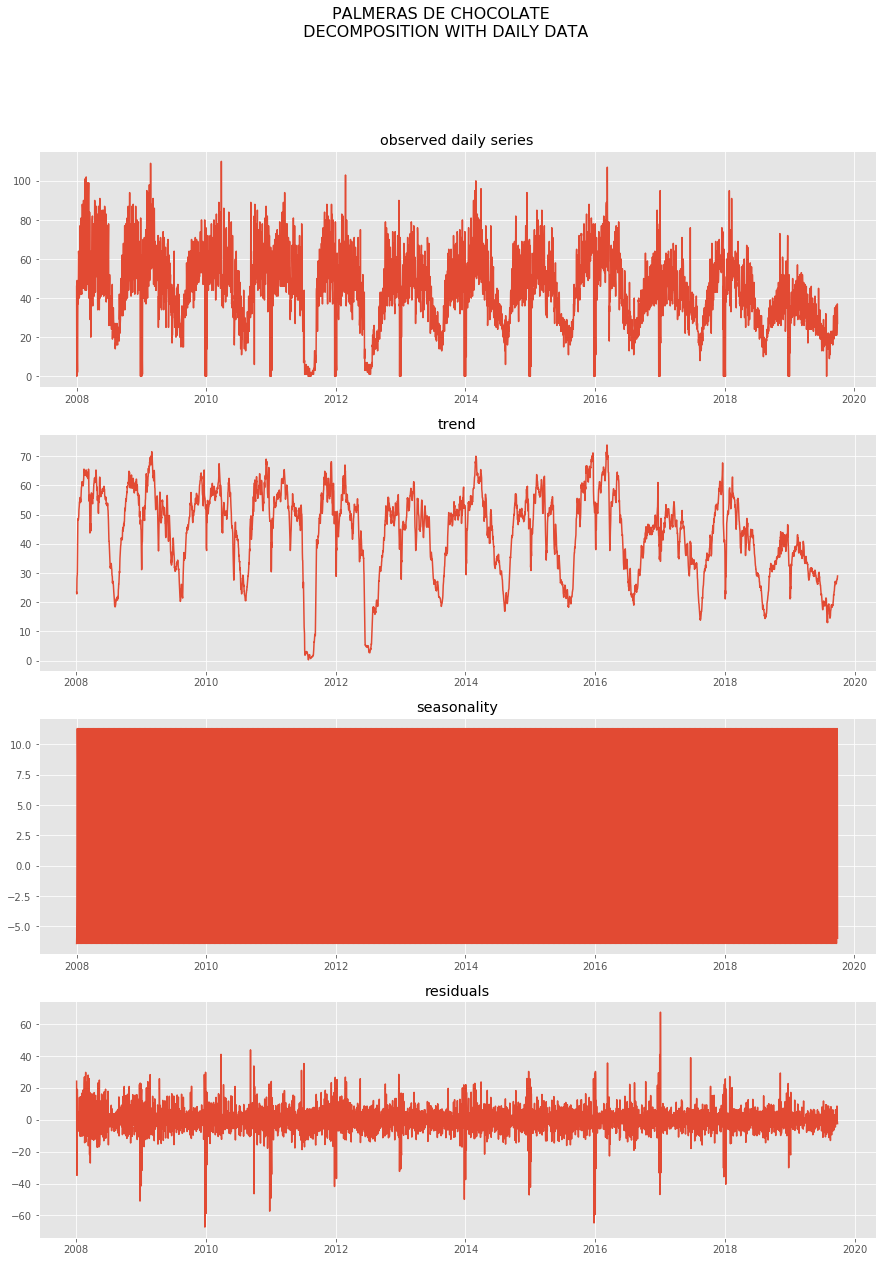

In [20]:
decomposition = seasonal.seasonal_decompose(palmera_choco['units_ordered'], model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,20))

fig.suptitle('PALMERAS DE CHOCOLATE \n DECOMPOSITION WITH DAILY DATA', fontsize=16)

ax1.plot(decomposition.observed)
ax1.set_title('observed daily series')

ax2.plot(decomposition.trend)
ax2.set_title('trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('seasonality')

ax4.plot(decomposition.resid)
ax4.set_title('residuals');


We cannot see a thing with the whole series, due to the constraints of the image. We are going to run the same procedure with just one year of data:

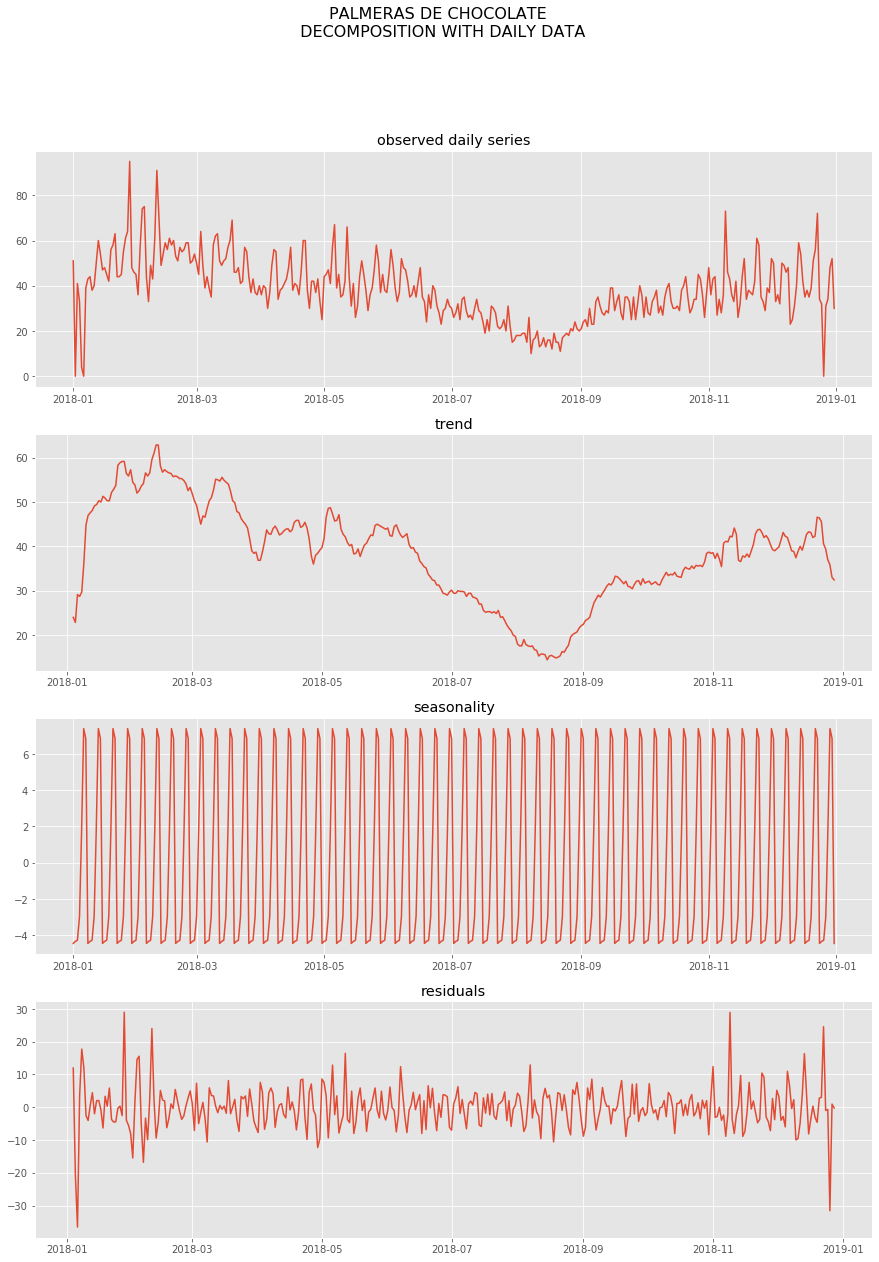

In [21]:
decomposition = seasonal.seasonal_decompose(palmera_choco.loc['2018','units_ordered'], model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,20))

fig.suptitle('PALMERAS DE CHOCOLATE \n DECOMPOSITION WITH DAILY DATA', fontsize=16)

ax1.plot(decomposition.observed)
ax1.set_title('observed daily series')

ax2.plot(decomposition.trend)
ax2.set_title('trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('seasonality')

ax4.plot(decomposition.resid)
ax4.set_title('residuals');

From this decomposition we can extract two main conclusions:

* There is a strong seasonality week component.

* As we can see, the dcomposition is not working well for the series of the daily data. Let's see what it can do with the series of monthly averages:

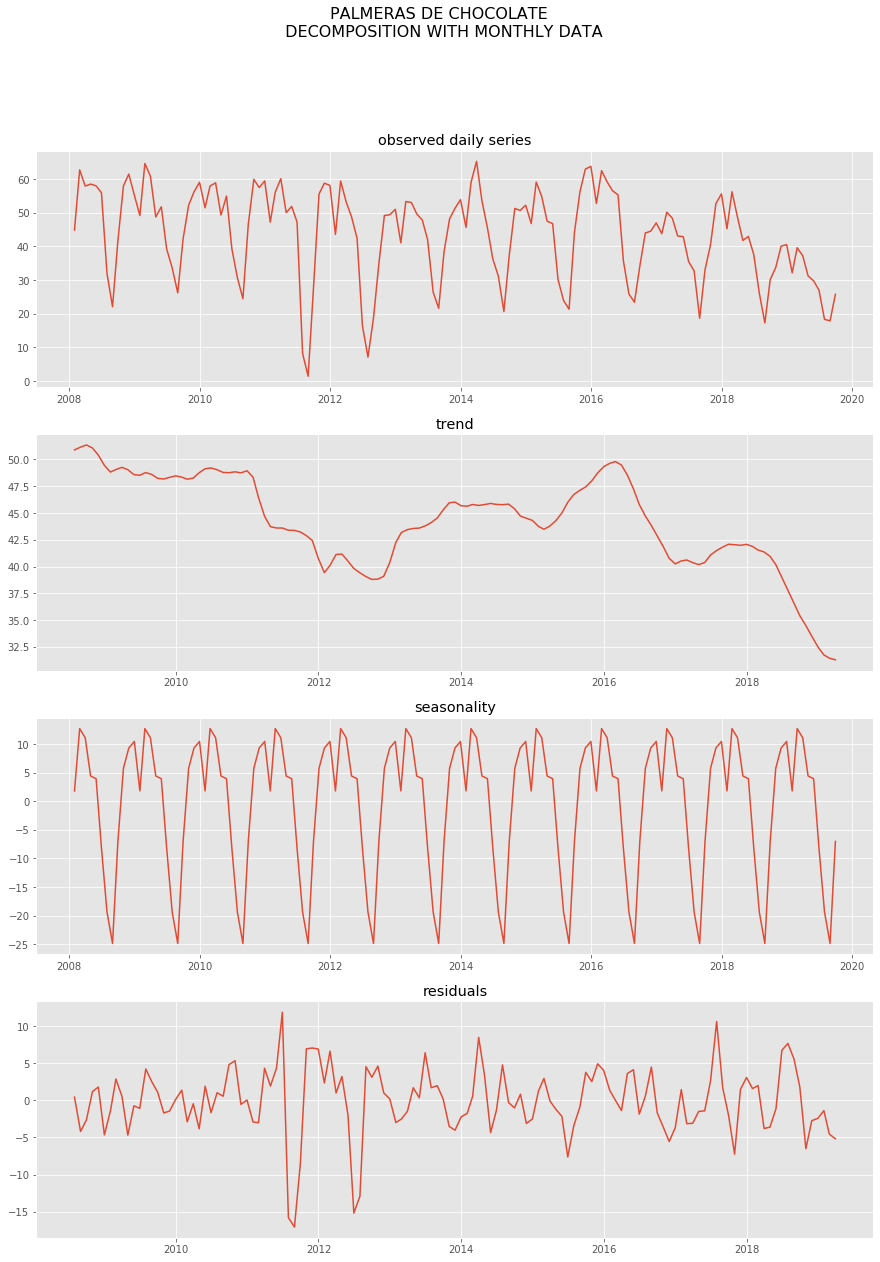

In [22]:
decomposition = seasonal.seasonal_decompose(monthly, model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,20))

fig.suptitle('PALMERAS DE CHOCOLATE \n DECOMPOSITION WITH MONTHLY DATA', fontsize=16)

ax1.plot(decomposition.observed)
ax1.set_title('observed daily series')

ax2.plot(decomposition.trend)
ax2.set_title('trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('seasonality')

ax4.plot(decomposition.resid)
ax4.set_title('residuals');

# 2) Models application<a id='a2'></a>

### 2.0) Split Train-Test, selecting the metric for our errors and setting benchmarks<a id='a20'></a>

For cross-validation purposes we are going to create a series of 10 randomly-picked intervals for our series.

The horizon to forecast will be of one week, which is the horizon demanded by the client.

Also, as we know, both exponential methods and ARIMA methods loose effectiveness (ARIMA methods loose everything but the trend) from a number of steps head on. So, trying to forecast big intervals ahead is not sensible.

For machine learning methods we will have to train one model for each day ahead that we want to predict, so, trying to predict many days in advance would require training the same number of different machine learning models, one for each day.

The data used to train our models will be the year before that week. Doing it so, we know that we loose the yearly-pattern seasonality that we found.

We initially don't care for this yearly seasonality.

The motives are as follow:
    
1) for each model, including lags up to the 365 is clearly excessive.

2) if it is necessary, to include the yearly seasonality would be easy, we would need only to differenciate the series with its 365th lag, and run this same models on the resulting series.

3) we can also calculate the mean values for a cycle of 365 days and take it from the series, and operate with the resulting series.



In [23]:
series = palmera_choco["units_ordered"]

random.seed(17)

number_of_validations = 10
horizon = 7
data_for_pred = 365*3

cross_val_dict=dict()

for i in range(number_of_validations):
    ran_num = random.randint(data_for_pred,len(series)-horizon)
    ran_test_dates = series.reset_index().iloc[ran_num:ran_num + horizon]['order_date']
    ran_train_dates = series.reset_index().iloc[ran_num - data_for_pred:ran_num]['order_date']

    test = series[ran_test_dates]
    train = series[ran_train_dates]

    cross_val_dict[i+1]=[train, test]

### Selecting the metric for our errors
 
We initially thought of the MAPE (mean absolute percentage error) as our reference value for error calibration between methods, accompained with the Aikike Information Criterion when trying to stablish the best model within its method class, as for many of them (particularly, the ARIMA family methods and the Random Forest) the number of variables used is part of the model itself.
 
However, using the AIC when comparing between models of different families didn't seem sensible, as:
 
1) The different numeric methods might have different data needs, and the AIC might be penalizing excessively a particular method and model, when, at the same time, the method is returning models with greater accuracies by other, more interpretable error measures.
 
2) The AIC has no direct, "real world" interpretation, as other error metrics (such as the MAPE) have.
 
Now, in regards of using the MSE and not the MAPE was due to the presence in our series of 0 and close-to-0 values, where this metric is known to be not only not numerically unstable, but also not reliable.
 
In fact, after trying it out initially, many problems arose, and we decided to change to a more stable and usable metric.
 
MSE presents also some interesting properties itself:
 
1) It is used (as the MAPE) for analyzing performance in numeric methods
 
2) It is closely related with variance measures
 
3) It can be used both for stimator and predictor accuracy (not important in our case)
 
4) Minizing MSE means also to minimize the sum of distances between prediction and real values, so by minimizing the MSE we are ensuring that our predictions are the closest in mean to the real values

We create now an empty dictionary where we will input the error obtained by each method used:

In [24]:
# Error per model Dictionary
mse_all_models = {} 

We are now going to set our benchmarks for comparison:

**BENCHMARK 1:**

USING THE MEAN AS A GUESS:

Our first "model" will be: Using the mean (of the previous year) as a guess (the most basic model). This first value will provide us with a first tool to calibrate the other two models that we are going to use for benchmarking our time series and machine learning models.

As we said before, we are going to cross-validate our results running each model 10 times in different, randomly-picked, parts of the series, obtaining the mean of the mean squared errors commited, and the mean distribution of those mean squared errors:

In [25]:
mean_mse_mean = 0
mean_mse_series_mean =np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    train_mean = train.mean()
    print("mean (model predicted value):", train_mean)
    squared_dif_series=(test - train_mean)**2
    print("MSE:", (squared_dif_series).mean())
    
    mean_mse_mean += (squared_dif_series).mean()
    
    mean_mse_series_mean += np.array(squared_dif_series)

mean_mse_mean = mean_mse_mean/number_of_validations
mean_mse_series_mean=pd.Series(mean_mse_series_mean/horizon)

print("mean MSE:", mean_mse_mean)

mean (model predicted value): 46.02648401826484
MSE: 82.3469505878288
mean (model predicted value): 44.04474885844749
MSE: 428.5445986769013
mean (model predicted value): 42.33607305936073
MSE: 100.47824190488107
mean (model predicted value): 43.010958904109586
MSE: 503.44082459855787
mean (model predicted value): 42.37899543378995
MSE: 348.1886473235695
mean (model predicted value): 44.099543378995435
MSE: 285.67644508782433
mean (model predicted value): 37.853881278538815
MSE: 356.22487318565385
mean (model predicted value): 42.31780821917808
MSE: 77.5792799506742
mean (model predicted value): 42.340639269406395
MSE: 131.9669157380848
mean (model predicted value): 45.64566210045662
MSE: 61.59574451861185
mean MSE: 237.60425215725877


As we can see, there is a big dispersion in the MSE values, depending on the series used. This remarks the great importance of using cross-validation techniques when evaluating a model.

The MSE for this burd method is 222, aproximately.

We now plot the results for the last of our models:

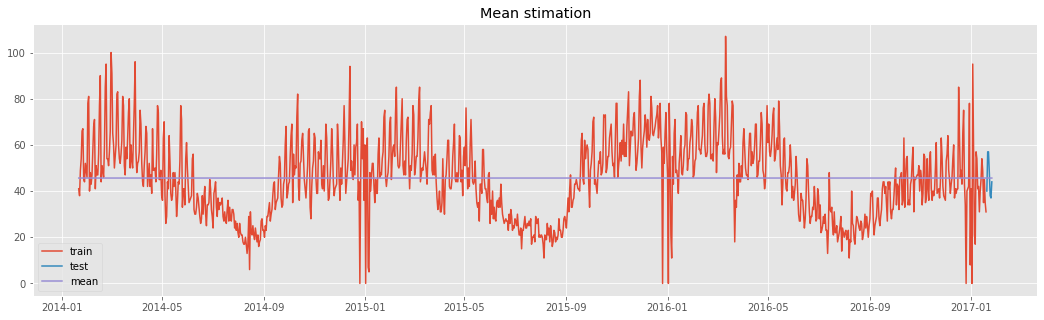

In [26]:
mean_model = pd.Series(train_mean, index = train.index.union(test.index))

plt.plot(train)
plt.plot(test)
plt.plot(mean_model)
plt.legend(['train','test','mean'])
plt.title("Mean stimation");

As we can see, the mean fails to capture any trend along the cycle, nor the weekly seasonality.

Evidently, the results should get better when replacing this simple average with a moving average that follows the series, but the purpose of this method is just setting a benchmark.

In [27]:
mse_all_models["general_mean"] = mean_mse_mean

**BENCHMARK 2:**
    
MEAN OF JUST SAME DAYS OF THE WEEK:
    
Now we will use as our guess the mean of the values of the same weekday of the year before:

Firstly, to compare this model to the previous one, we are going to check it just for a particular one: the last scenario of the 10 randomly defined for our cross-validation purposes:

In [28]:
data = cross_val_dict[number_of_validations-1]
train = data[0]
test = data[1]

In [29]:
train_means_by_weekday = train.groupby(train.index.weekday).mean()
print(train_means_by_weekday)
print("mean value for the same series:", train_mean)

order_date
0    37.512821
1    37.509554
2    38.917197
3    39.337580
4    44.756410
5    49.051282
6    49.371795
Name: units_ordered, dtype: float64
mean value for the same series: 45.64566210045662


As we can see, when compared with the general mean, we have now a series of values, one for each weekday, that present  certain dispersion. 

As now our guesses should be wiser, our median average error should go down, but any scenario is possible a priori.

In [30]:
mean_mse_mult_means = 0
mean_mse_series_mult_means =np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    train_means_by_weekday = train.groupby(train.index.weekday).mean()
    test_df=test.reset_index()
    test_df['weekday'] = test.index.weekday
    df_train_means_by_weekday = train_means_by_weekday.reset_index()
    df_train_means_by_weekday.columns = ['weekday','prediction']

    test_result_merged = pd.merge(test_df, df_train_means_by_weekday, how='inner', on='weekday')
    test_result_merged.set_index(test_result_merged['order_date'], inplace=True)
    test_result_merged.sort_index(inplace=True)
    
    test_result_merged['Sq_error'] = (test_result_merged['units_ordered'] - test_result_merged['prediction'])**2

    mean_mse_mult_means += test_result_merged['Sq_error'].mean()
    
    mean_mse_series_mult_means += np.array(test_result_merged['Sq_error'])
    
    print("MSE:", test_result_merged['Sq_error'].mean())
    
mean_mse_mult_means = mean_mse_mult_means/number_of_validations
mean_mse_series_mult_means=pd.Series(mean_mse_series_mult_means/horizon)

print("mean MSE:", mean_mse_mult_means)

MSE: 44.72322681486867
MSE: 440.6850644700416
MSE: 30.113960343697013
MSE: 401.92245997403614
MSE: 277.0853750346516
MSE: 160.58068672653775
MSE: 369.7679498097784
MSE: 29.045083230127023
MSE: 49.99009894733081
MSE: 20.364860502590965
mean MSE: 182.427876585366


We can see that our predictions are better, because our mean error has dropped almost 30%.

We want to remark, again, the dispersion of the values and the importance of using cross-validation techniques.

Now, we plot the values of the model against the real values, for the last iteration:

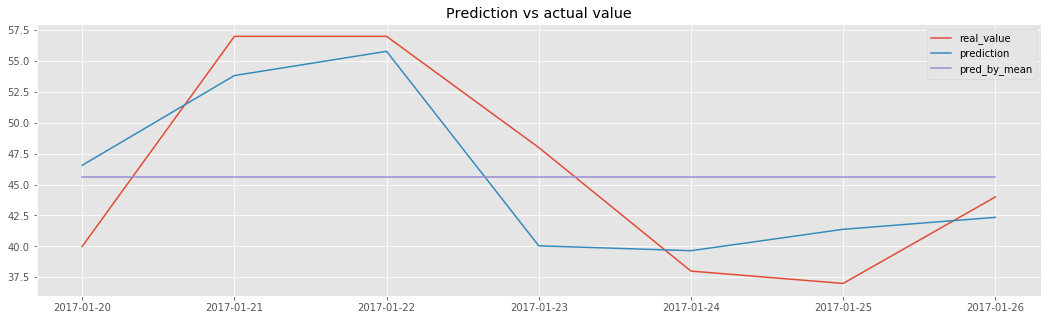

In [31]:
plt.plot(test_result_merged['units_ordered'])
plt.plot(test_result_merged['prediction'])
plt.plot(mean_model[test.index])
plt.legend(['real_value','prediction','pred_by_mean'])
plt.title('Prediction vs actual value');

As we can see, not only the mean error commited is lower, but also, the new benchmark model now adjusts well to the weekly seasonality. 

Let's check now how this is translated in the distributions of the mean errors:

In [32]:
mse_all_models["weekday_means"] = mean_mse_mult_means

**BENCHMARK 3:**
    
NAÎVE GUESS:
    
Now we are going to predict the values of our series just by using the last value available, again, for the same day of the week.

In [33]:
mean_mse_naive = 0
mean_mse_series_naive =np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    train_bm3 = train[-horizon:]
    train_bm3.index = train_bm3.index + timedelta(days=7)
    pred_bm3 = test.shift(7)
    pred_bm3.fillna(0, inplace=True)
    pred_bm3[0:7] = pred_bm3[0:7] + train_bm3
    df_bm3 = pd.DataFrame(test)
    df_bm3['prediction'] = pred_bm3
    df_bm3['Sq_error'] = (df_bm3['units_ordered'] - df_bm3['prediction'])**2
    df_bm3['Sq_error'].mean()
    
    print("MSE:", df_bm3['Sq_error'].mean())
    
    mean_mse_naive += df_bm3['Sq_error'].mean()   
    mean_mse_series_naive += np.array(squared_dif_series)
    
mean_mse_naive = mean_mse_naive/number_of_validations
mean_mse_series_naive = pd.Series(mean_mse_series_naive/horizon)

print("mean MSE:", mean_mse_naive)

MSE: 42.714285714285715
MSE: 24.285714285714285
MSE: 120.0
MSE: 89.14285714285714
MSE: 141.42857142857142
MSE: 67.28571428571429
MSE: 120.28571428571429
MSE: 38.857142857142854
MSE: 74.85714285714286
MSE: 69.85714285714286
mean MSE: 78.87142857142858


We can see that the mean MSE has almost halved. This suggests that guessing the values of the series with the same equivalent value from a week ago is a much better guess than using averages of any kind, what in turn, tells us that using just a small series of lags should give us good predictions.

This is not very strange, as we saw that the series has a yearly seasonality, appart from the weekly seaonality. So, the average yearly values for each day of the week are not taking into consideration the month of the year in which we are.

In this regard, the last value for the same day of the week, although imperfectly, will normally contain the cicle information, and will be more precise.

Quite possibly, averaging the last week-equivalent days for the last month would yield results better to both the weekday yearly averages and this Naîve-guess method.

Now, plotting the distributions:

Text(0.5, 1.0, 'Prediction vs actual value')

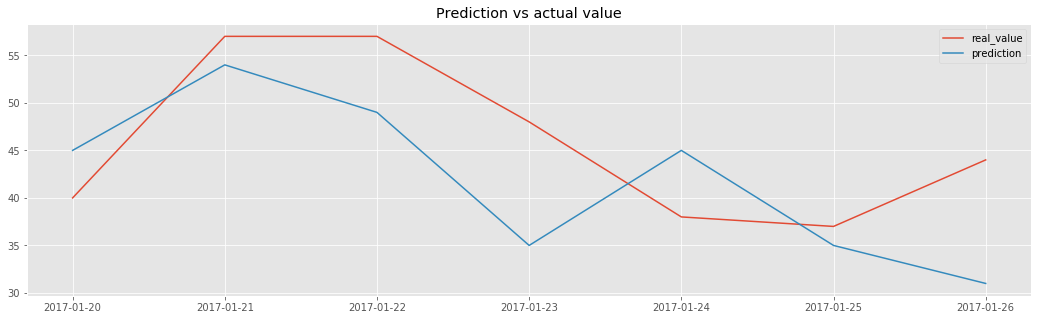

In [34]:
plt.plot(df_bm3['units_ordered'])
plt.plot(df_bm3['prediction'])
plt.legend(['real_value','prediction'])
plt.title('Prediction vs actual value')

We can see that the series again is capable of adjusting to the week pattern, as in the previous case.

Let's see now the distribution of errors for all these benchmark errors:

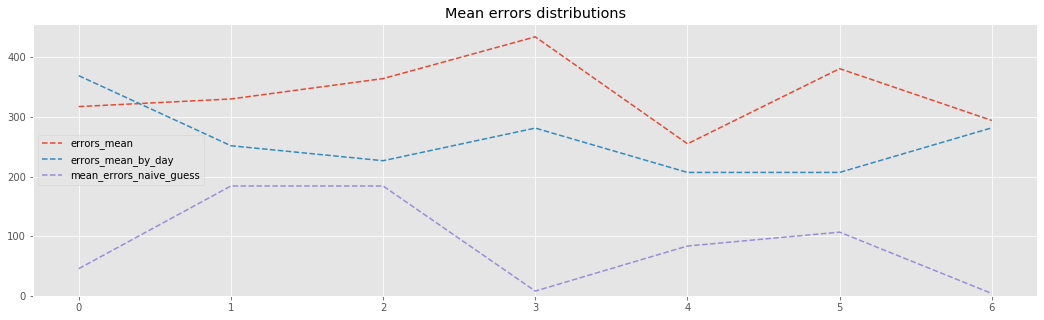

In [35]:
fig, ax =plt.subplots()


ax.plot(mean_mse_series_mean, '--')
ax.plot(mean_mse_series_mult_means, '--')
ax.plot(mean_mse_series_naive, '--')
ax.legend(['errors_mean','errors_mean_by_day', 'mean_errors_naive_guess'])
ax.set_ylim(bottom=0)
plt.title('Mean errors distributions');

As we can see, when comparing the mean error commited by the weekday-wise mean when compared with the mean, our error is not only significantly lower, but also more uniform in its distribution along time, which is another factor to keep in mind.

This property is somehow lost for the weekday-wise Naîve-guess, however.

In [36]:
mse_all_models["Naîve_guess"] = mean_mse_naive

We can see that, in this case, not only we have a more homogeneous distribution of error, but also that they are all lower than in two previous cases.

**CONCLUSIONS:**

**The information just previous to our forecast seems to be of greater value than historical data.**

**As we could see earlier, the weekly pattern is of great importance in this series, and has to be acknowledged.**

**Any model with a mean MSE greater than 82 will behave worse than a mere naîve guess (using the same value of the previous week). We will use this value as a threshold, but all three values (214 for the mean, 172 for the weekly means and 82 for the naîve guess) to compare with those of our methods.**

**From the disperssion of the values of MSE obtained for each of these three methods we can infer the great importance of doing cross-validation of the different methods.**

Now, we can start evaluating different methods.

### 2.1) TIME SERIES METHODS<a id='a21'></a>

Now, we can start using time series methods for our forecasts.

### 2.1.1) EXPONENTIAL MODELS<a id='a211'></a>

Each model consists of a measurement equation that describes the observed data, and some state equations that describe how the unobserved components or states (level, trend, seasonal) change over time. Hence, these are referred to as state space models.

For each method there exist two models: one with additive errors and one with multiplicative errors. The point forecasts produced by the models are identical if they use the same smoothing parameter values. They will, however, generate different prediction intervals.

We label each state space model as ETS(.,.,.) for (Error, Trend, Seasonal). This label can also be thought of as ExponenTial Smoothing, where  the possibilities for each component are:

 - Error: Additive, Multiplicative
 - Trend: None, Additive, Additive and damped
 - Seasonal: None, Additive, Multiplicative
 
 
 This leads to the following map:
 
<img src=".\images\statespacemodels.png" style="width: 620px;">


Three of the combinations of (Error, Trend, Seasonal) can lead to numerical difficulties. Specifically, the models that can cause such instabilities are ETS(A,N,M), ETS(A,A,M), and ETS(A,Ad,M), due to division by values potentially close to zero in the state equations. We normally do not consider these particular combinations when selecting a model.

Models with multiplicative errors are useful when the data are strictly positive, but are not numerically stable when the data contain zeros or negative values. Therefore, multiplicative error models will not be considered if the time series is not strictly positive. In that case, only the six fully additive models will be applied.

Source:

https://otexts.com/fpp2/ets.html

So, being that our case, we will opt for an Additive Holt-Winters’ method (an exponential method with additive trend and additive seasonality) with additive errors.

This model is atractive for us, because it can detect trends and supports seasonality, which in our case is a weekly seasonality.

In [37]:
mean_mse_ES = 0
mean_mse_series_ES =np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    ES_model = ExponentialSmoothing(train, trend='add', seasonal='add', damped=False, seasonal_periods=7)
    ES_model = ES_model.fit()

    ES_resid = ES_model.resid
    ES_aic = ES_model.aic

    ES_pred = ES_model.predict(start = test.index[0], end = test.index[-1])

    ES_mse = (test - ES_pred)**2
    
    print("MSE:", ES_mse.mean())
    
    mean_mse_ES += ES_mse.mean()   
    mean_mse_series_ES += np.array(ES_mse)
    
mean_mse_ES = mean_mse_ES/number_of_validations
mean_mse_series_ES = pd.Series(mean_mse_series_ES/horizon)

print("mean MSE:", mean_mse_ES)

MSE: 39.820041722502765
MSE: 13.942023566603226
MSE: 119.35917762011195
MSE: 32.54837767935966
MSE: 82.78951999776571
MSE: 49.22538755843362
MSE: 30.735821366061128
MSE: 38.98787007226826
MSE: 57.581917932957204
MSE: 99.75991977852888
mean MSE: 56.475005729459234


As we can see, our MSE is lower than the naîve guess value that we decided would be our threshold.

So, a priori, this model improves our situation over just selecting the last value for the same weekday, and would eligible.

Let's plot now the last prediction and the real series:

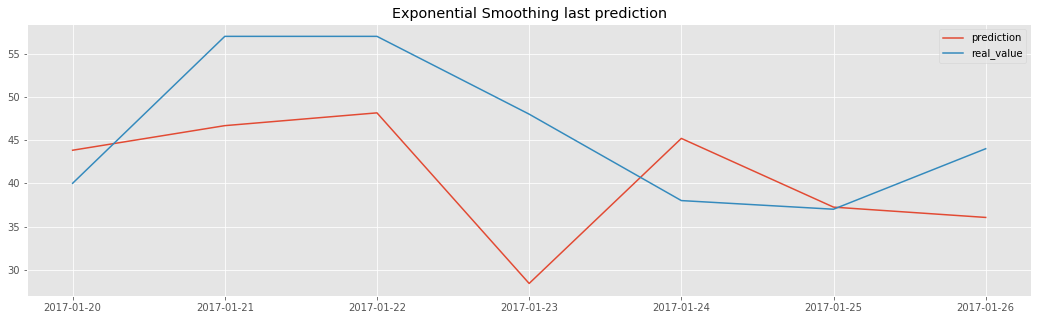

In [38]:
plt.plot(ES_pred)
plt.plot(test)
plt.legend(['prediction','real_value'])
plt.title("Exponential Smoothing last prediction");

**RESIDUALS CHECKS**
 
We are going to check now the residuals of this method. As we know, it is required for them that:
 
1) They have a mean of 0: if they have not, a better model can be simply achieved, by adding a constant term with the difference.
   
2) They are  uncorrelated: if they are not, there are some more correlations to be exploited that could result in a better model for us.
 
Also, it is not required, but convenient that:
 
3) They have constant variance
 
4) They follow a gaussian distribution
 
This requirement can ensure the p-values and confidence intervals for the predictions. We are not going to give ranges of orders for our predictions and a confidence level (as our client is not trained in statistics and wouldn't know what to do with such information), but it is interesting to check this requirement in the case we changed our minds on that issue.
 
To check this four requirements we are going to use:
 
1) acf to plot correlations, and Liung-Box test
 
2) residuals plot and give their mean
 
3) residuals plot
 
4) histogram, Q-Q test and Shapiro-Wilk test
 
We are going to create a function now, that do all these checks and then apply it method by method:

**For the Liung-Box test:**

In general, the Box-Ljung test is defined as:
H0:	The model does not exhibit lack of fit.
Ha:	The model exhibits lack of fit.

Hyndman http://robjhyndman.com/hyndsight/ljung-box-test/ recommends:

*"In my forecasting textbook with George Athanasopoulos, we recommended using h = 10 for non-seasonal data and h=2m for seasonal data, where m is the period of seasonality. "*

As our data is seasonal, with period 7 days (we cannot see the yearly seasonality, as we took only 1 year of data), the number of lags for the test will be 14.

For the ARIMA models (this metric is specially used for these models), the number of lags is dictated by h-p-q.

In [39]:
def residual_checking(res_series, lbtlags=14):
    
    plt.plot(res_series)
   
    plot_acf(res_series, lags=30)
   
    ljungbox_test = acorr_ljungbox(res_series, lags=lbtlags, boxpierce=False)
    
    print("residuals mean:", res_series.mean())
   
    print("Ljung-Box test results:\n")
    
    fig1, ax1 =plt.subplots()
    ax1.plot(ljungbox_test[1])
    
    if max(ljungbox_test[1])<0.05:
        print("Ljung-Box test says there are still some significant autocorrelations")
        
    else:
        print("Ljung-Box test says there are no significant autocorrelations\n")
      
    fig2, ax2 =plt.subplots()
    ax2.hist(res_series, bins=30)
   
    qqplot(res_series)
   
    shapiro_test = shapiro(res_series)
   
    print("Shapiro–Wilk test results:\n", shapiro_test)
    
    if shapiro_test[1]<0.05:
        print("Shapiro–Wilk test indicates the residuals do not follow a Gaussian distribution\n")
        
    else:
        print("Shapiro–Wilk test indicates the residuals follow a Gaussian distribution")
        
    return ljungbox_test

residuals mean: -0.04604017624928932
Ljung-Box test results:

Ljung-Box test says there are still some significant autocorrelations
Shapiro–Wilk test results:
 (0.8935598731040955, 7.720493856992578e-27)
Shapiro–Wilk test indicates the residuals do not follow a Gaussian distribution



(array([ 30.26467533,  34.01788514,  71.4568411 ,  77.8156264 ,
         79.18985252,  86.54948699,  90.47619511,  90.66803546,
         92.30617275,  95.1534807 ,  96.90181288,  97.16141354,
         99.87540927, 100.03840065]),
 array([3.76928481e-08, 4.10308107e-08, 2.08094724e-15, 5.05369880e-16,
        1.23968539e-15, 1.57587331e-16, 9.87758934e-17, 3.40290691e-16,
        5.60379794e-16, 5.06197788e-16, 7.31831351e-16, 1.99934066e-15,
        1.75385515e-15, 4.66273988e-15]))

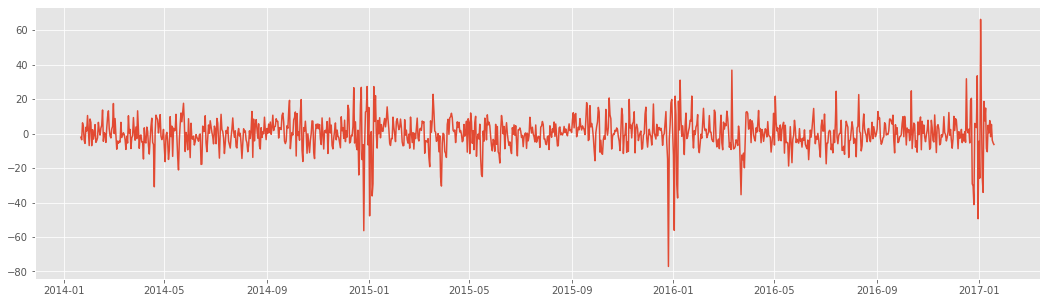

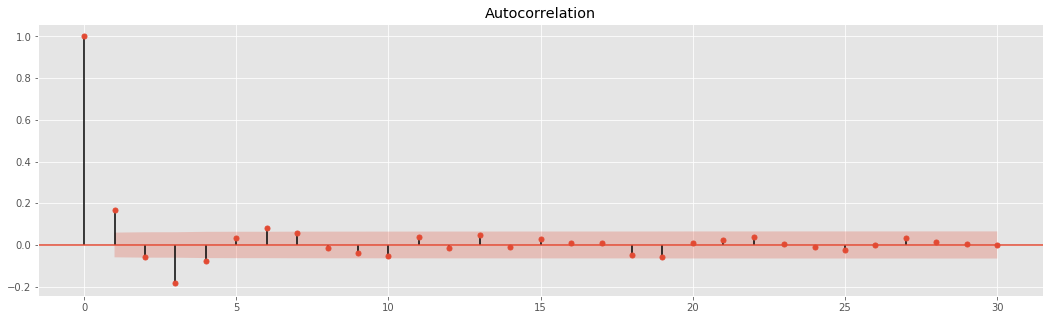

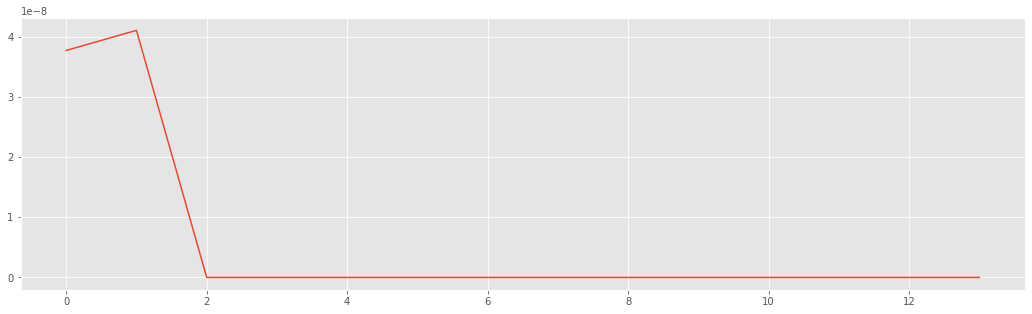

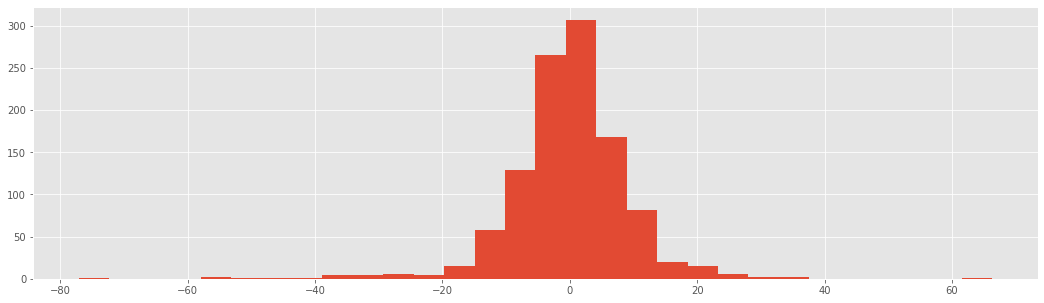

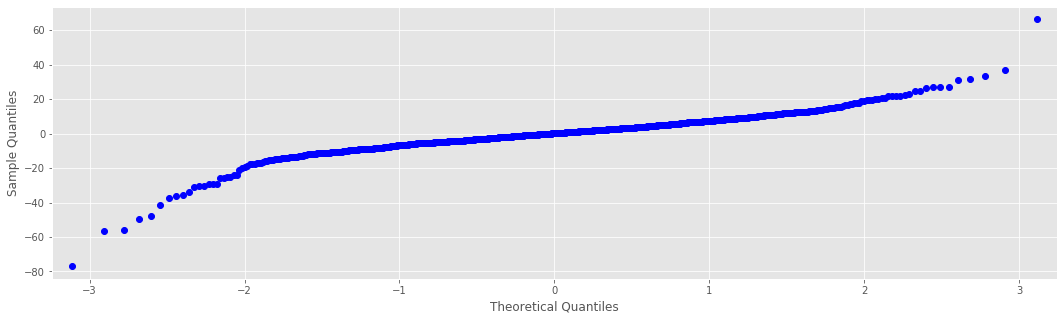

In [40]:
residual_checking(ES_resid)

As we can see from running the tests:
    
The mean value is close to zero.

The Ljung-Box test indicates that there are still some significant autocorrelations to exploit, and actually the acf of the residuals indicate some moderate autocorrelations for lags 1 and 3 (altough they are so close to the 5% chance region that they very possibly they have been produced by chance).

On the other hand:
    
Both the Q-Q plot (such a flat shape indicates heavy tails) and the Shapiro–Wilk test indicates that the distribution is not normal, and the variance doesn't seem to be constant (although more careful checks should be done in this sense).

If the model is well suited, the variance of the returns is not a problem of the model, but a characteristic of the data.

So we should get the same result for all the rest of the models that only handle the information contained in the series.

The problem asociated with this, is that we would no longer be able to predict confidence intervals based on a normal distribution of the temporal variable.



In [41]:
mse_all_models["Holt-Winters"] = mean_mse_ES

### 2.1.2) ARIMA<a id='a212'></a>

Now we are going to try out the standard ARIMA model.

From the analysis performed during the first part of our notebook, (specifically, from the acf and pacf analysis) we know that an AR(7) model is in order.

We also know, as the series is already stationary, that no differencing would be needed, although can be convenient.

Let's study the matter a little more in depth:

**CHECKING FOR DIFFERENCING:**

We are now going to check the optimal order of differencing for our series. We will follow the following rules:

Identifying the order of differencing and the constant:

Rule 1: If the series has positive autocorrelations out to a high number of lags (say, 10 or more), then it probably needs a higher order of differencing.

Rule 2: If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.  BEWARE OF OVERDIFFERENCING.

Rule 3: The optimal order of differencing is often the order of differencing at which the standard deviation is lowest. (Not always, though. Slightly too much or slightly too little differencing can also be corrected with AR or MA terms. See rules 6 and 7.)

Rule 4: A model with no orders of differencing assumes that the original series is stationary (among other things, mean-reverting). A model with one order of differencing assumes that the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that the original series has a time-varying trend (e.g. a random trend or LES-type model).

Rule 5: A model with no orders of differencing normally includes a constant term (which allows for a non-zero mean value). A model with two orders of total differencing normally does not include a constant term. In a model with one order of total differencing, a constant term should be included if the series has a non-zero average trend.

Source: https://people.duke.edu/~rnau/arimrule.htm
    
If the differenced series presents a negative correlation with its lag-1 value, the series would be slighly overdifferenced:

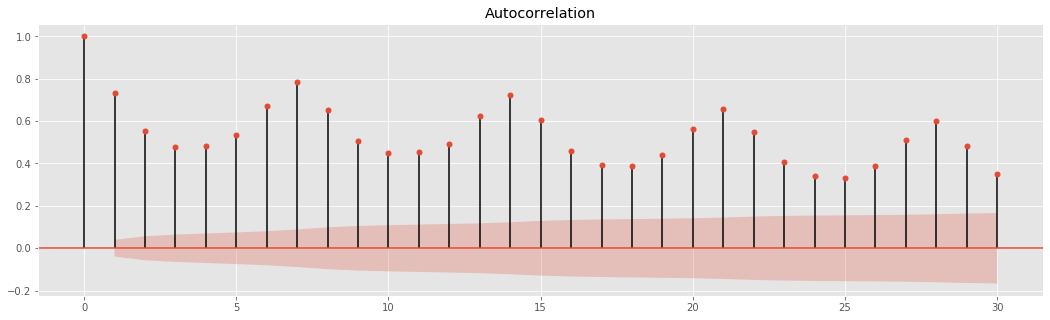

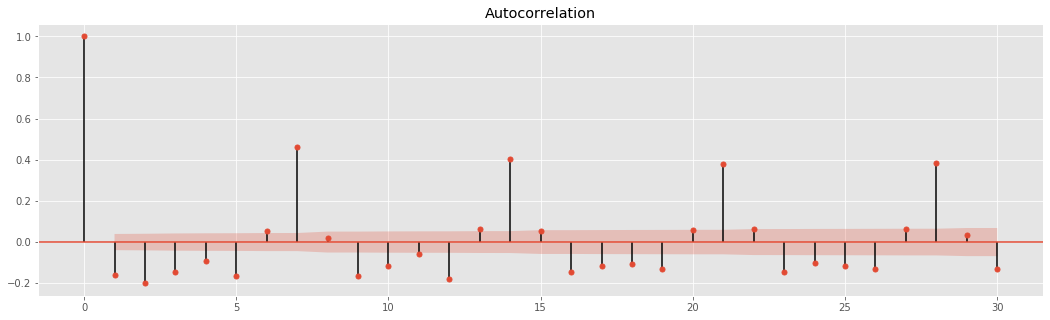

In [42]:
dif_series_1 = series.diff(1).dropna()
plot_acf(series, lags = 30, alpha= 0.01)
plot_acf(dif_series_1, lags = 30, alpha= 0.01);

In [43]:
print(series.std())
print(dif_series_1.std())

18.076183830888187
13.226164709895148


Following the rules, the order of differencing for our models can only be 0 or 1.

0 because it is already stationary, and an AR(7) model seems appropriate to deal with the existing autocorrelations up to lag 7, but, as shown above, it seems also appropriate to use a d=1, to remove the effect of lag 1 in the series, and let the AR part of the model deal with the rest of the autocorrelations.

we are going to try out both strategies.

**STIMATING THE MA COEFFICIENTS:**

What we don't know yet is the coefficient for the MA part of the model.

As we know, if the acf had returned a spike (for instance, at lag 1), but not any other spike at any multiples of this lag, that would indicate the existence of an MA component, of order, the order of the lag (in case of the presence of a spike at lag 1, and not any other lag, that would lead us to a MA(1) model).

Nevertheless, when there are effects of an autoregression, they can compound to the effects of a possible MA.

Or as it is expressed in https://people.duke.edu/~rnau/411arim3.htm:

*AR and MA signatures: If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more easily by adding AR terms than by adding MA terms. You will probably find that an AR signature is commonly associated with positive autocorrelation at lag 1--i.e., it tends to arise in series which are slightly underdifferenced. The reason for this is that an AR term can act like a "partial difference" in the forecasting equation. For example, in an AR(1) model, the AR term acts like a first difference if the autoregressive coefficient is equal to 1, it does nothing if the autoregressive coefficient is zero, and it acts like a partial difference if the coefficient is between 0 and 1. So, if the series is slightly underdifferenced--i.e. if the nonstationary pattern of positive autocorrelation has not completely been eliminated, it will "ask for" a partial difference by displaying an AR signature.

(...)

*In principle, any autocorrelation pattern can be removed from a stationarized series by adding enough autoregressive terms (lags of the stationarized series) to the forecasting equation, and the PACF tells you how many such terms are likely be needed. However, this is not always the simplest way to explain a given pattern of autocorrelation: sometimes it is more efficient to add MA terms (lags of the forecast errors) instead. The autocorrelation function (ACF) plays the same role for MA terms that the PACF plays for AR terms--that is, the ACF tells you how many MA terms are likely to be needed to remove the remaining autocorrelation from the differenced series. If the autocorrelation is significant at lag k but not at any higher lags--i.e., if the ACF "cuts off" at lag k--this indicates that exactly k MA terms should be used in the forecasting equation. In the latter case, we say that the stationarized series displays an "MA signature," meaning that the autocorrelation pattern can be explained more easily by adding MA terms than by adding AR terms.*

For identifying the numbers of the MA terms we will follow the following rules:

Identifying the numbers of AR and MA terms:

Rule 6: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

Rule 7: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

Rule 8: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.

Rule 9: If there is a unit root in the AR part of the model--i.e., if the sum of the AR coefficients is almost exactly 1--you should reduce the number of AR terms by one and increase the order of differencing by one.

Rule 10: If there is a unit root in the MA part of the model--i.e., if the sum of the MA coefficients is almost exactly 1--you should reduce the number of MA terms by one and reduce the order of differencing by one.

Rule 11: If the long-term forecasts* appear erratic or unstable, there may be a unit root in the AR or MA coefficients.

So, from the above acf, we can see that, if we go for a d=0 model, the MA is difficult to determine (we will pick MA=0 and MA=1 in this case)

For a d=1 model, it seems that the we should go for a MA=7 model.

So, our candidates should be ARIMA(7,0,0), ARIMA(7,0,1), ARIMA(7,0,7), ARIMA(7,1,0), ARIMA(7,1,1) and ARIMA(7,1,7)

To these models, we are going to add a bunch of other models as control for the AIC criterion (maybe we can do good enough using less information, and we want to check that we are doing things right).

(We need to keep in mind the need for invertibility of the coefficients of the MA model)

Firstly, we take define the models we are going to try out:

In [44]:
orders=[(1,0,0),(1,0,1),(2,0,0),(2,0,1),(7,0,0),(7,0,1),(7,0,7),(7,1,0),(7,1,1),(7,1,2),(7,1,7)]

Secondly, we select one specific set of train, test conditions:

In [45]:
data = cross_val_dict[number_of_validations-1]
train = data[0]
test = data[1]

We now try out a single ARIMA model on such conditions:

In [46]:
order = (7,1,1)

ARIMA_model = ARIMA(train, order = order)
ARIMA_model = ARIMA_model.fit()

print(ARIMA_model.summary)

ARIMA_resid = ARIMA_model.resid
ARIMA_aic = ARIMA_model.aic

if order[1] == 0:
    ARIMA_pred = ARIMA_model.predict(start = test.index[0], end = test.index[-1])
else:
    ARIMA_pred = ARIMA_model.predict(start = test.index[0], end = test.index[-1], typ='levels')

ARIMA_mse = (test - ARIMA_pred)**2

print(ARIMA_mse.mean())
print(ARIMA_aic)

<bound method ARMAResults.summary of <statsmodels.tsa.arima_model.ARIMAResults object at 0x0000024A3C0B2F98>>
96.731983038442
8027.928697968155


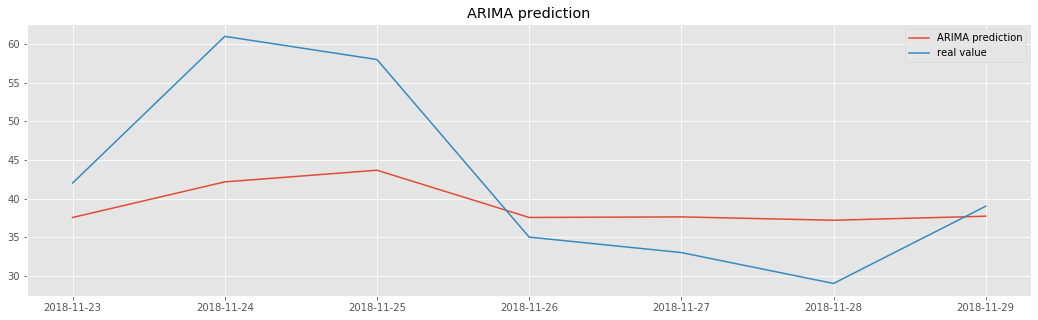

In [47]:
# Plot the original series and the forecasted series
plt.plot(ARIMA_pred)
plt.plot(test)
plt.legend(["ARIMA prediction", "real value"])
plt.title("ARIMA prediction");

We define now a function that obtains all this values for us:

In [48]:
# evaluate an ARIMA model:

def eval_arima_model(arima_order, train , test):
    
    # Making sure that what the model reveives is a tuple:
    
    arima_order=tuple(arima_order)
    
    # Creatting and fitting the model:

    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    
    # Storing results:
    
    model_summary = model_fit.summary

    model_resid = model_fit.resid
    model_aic = model_fit.aic
    
    # Storing prediction:
    
    # The if-else clause is needed because the predict method requires to indicate how yo need your result in case
    # a model with differences is applied, but, on the other hand, doesn't handle the typ parameter when the model
    # works directly wiith the original series:
    
    if arima_order[1] == 0:
        model_prediction = model_fit.predict(start = test.index[0], end = test.index[-1])
    else:
        model_prediction = model_fit.predict(start = test.index[0], end = test.index[-1], typ='levels')

    # Calculate out of sample error:
    
    model_error = mean_squared_error(test, model_prediction)
    
    # Returning the values:
    
    return model_summary, model_prediction, model_resid, model_aic, model_error

Checking that the function works propperly:

In [49]:
ARIMA_summary, ARIMA_resid, yhat, ARIMA_aic, ARIMA_error = eval_arima_model((7,1,1), train, test)
print(ARIMA_error)
print(ARIMA_aic)
print(ARIMA_summary)
# print(ARIMA_resid)
# print(yhat)

96.731983038442
8027.928697968155
<bound method ARMAResults.summary of <statsmodels.tsa.arima_model.ARIMAResults object at 0x0000024A4722A208>>


Now, we use this function to try out several different combinations for the parameters of the ARIMA model.

We define below a function that receives the list or orders one wants to try, and the dictionary with the test and train information stored, and tries out for each scenario defined in this dictionary, for each model given:

In [50]:
# evaluate combinations of p, d and q values for an ARIMA model

def evaluate_ARIMA(orders, cross_val_dict):

    # Initializing variables:
    
    model_summ, model_pred, model_res, model_aic, model_error  = None, None, None, None, float("inf")
    b_model_summ, b_model_pred, b_model_res, b_mean_ARIMA_aic, b_mean_mse_ARIMA = None, None, None, None, float("inf")
    
    b_mean_mse_series_ARIMA = None
    
    # as in previous cases, we want to evaluate our errors on average, 
    #so we run our process several times to get mean values:

    for order in orders:
        
        # This is a loop control variable that exits all iterations over our test data if the model could not be fitted
        # for any of them:
        
        control=1
        
        mean_mse_ARIMA, mean_ARIMA_aic = 0, 0
        mean_mse_series_ARIMA = np.array([0.0]*horizon)
        
        for key, data in cross_val_dict.items():
    
            train = data[0]
            test = data[1]
            
            # tries to apply the eval_arima_model function with the order indicated.
            # if it does cannot apply it (because of irreversibility on the initial coefficients), prints a warning and breaks
            
            try:
                model_summ, model_pred, model_res, model_aic, model_error = eval_arima_model(order, train, test)
#                 print(order, key)
                
            except:
                print("ARIMA ", order," model could not be fitted for ", " test data nr. ", key)
                control=0
                continue
                
            # Aggregating the results for the current loop to the squared errors series, the total error and the aic
            # of our model:

            squared_dif_series = (model_pred - test)**2

            mean_mse_ARIMA += model_error
            mean_ARIMA_aic += model_aic

            mean_mse_series_ARIMA += np.array(squared_dif_series)
            
        # After all iterations, we divide by the number of validations to obtain mean values:

        mean_mse_ARIMA = mean_mse_ARIMA/number_of_validations
        mean_ARIMA_aic = mean_ARIMA_aic/number_of_validations
        mean_mse_series_ARIMA=pd.Series(mean_mse_series_ARIMA/horizon)
        
        # Now we store the values of the best model (in terms of MSE):

        if (mean_mse_ARIMA < b_mean_mse_ARIMA) & control==1:
            
            b_mean_mse_ARIMA = mean_mse_ARIMA
            b_mean_ARIMA_aic = mean_ARIMA_aic
            b_mean_mse_series_ARIMA = mean_mse_series_ARIMA

            b_model_summ, b_model_pred, b_model_res = model_summ, model_pred, model_res
            
            b_order = order
            
        # Printing out average error values for the current model:

        print('ARIMA %s MSE=%s AIC=%s' % (order, mean_mse_ARIMA, mean_ARIMA_aic))
        
    # Printing out average error values for the best model:
                    
    print('Best ARIMA %s MSE=%s AIC=%s' % (b_order, b_mean_mse_ARIMA, b_mean_ARIMA_aic))
    
    # Returning the data of the best model:
    
    return b_model_summ, b_model_pred, b_model_res, b_mean_ARIMA_aic, b_mean_mse_ARIMA, b_mean_mse_series_ARIMA

We are now ready to try out our models:

In [51]:
b_model_summ, b_model_pred, b_model_res, b_mean_ARIMA_aic, b_mean_mse_ARIMA, b_mean_mse_series_ARIMA = evaluate_ARIMA(orders, cross_val_dict)

ARIMA (1, 0, 0) MSE=204.3756954625496 AIC=8522.409246292342
ARIMA (1, 0, 1) MSE=189.5825799375196 AIC=8484.894135222463
ARIMA (2, 0, 0) MSE=203.32656448394877 AIC=8516.085022853042
ARIMA (2, 0, 1) MSE=128.92853240216274 AIC=8371.261848426422
ARIMA (7, 0, 0) MSE=64.3537474957731 AIC=8072.435188896864
ARIMA (7, 0, 1) MSE=65.13706859330523 AIC=8066.295757237221
ARIMA  (7, 0, 7)  model could not be fitted for   test data nr.  7
ARIMA  (7, 0, 7)  model could not be fitted for   test data nr.  8
ARIMA (7, 0, 7) MSE=47.43281072782405 AIC=6386.953932563481
ARIMA (7, 1, 0) MSE=73.07219207883853 AIC=8061.26004483725
ARIMA (7, 1, 1) MSE=74.79167288183304 AIC=8061.332325310816
ARIMA (7, 1, 2) MSE=75.92408882070694 AIC=8061.502667070345
ARIMA  (7, 1, 7)  model could not be fitted for   test data nr.  5
ARIMA  (7, 1, 7)  model could not be fitted for   test data nr.  7
ARIMA (7, 1, 7) MSE=45.38166344149481 AIC=6374.4200436085775
Best ARIMA (7, 0, 0) MSE=64.3537474957731 AIC=8072.435188896864


As we can see, our function has selected the ARIMA(7,1,1) model, in spite of existing other with smaller MSE values.

This is because in the function we defined that if the model could not be fitted for all the different scenarios, the model would not be eligible.

(In regards to those low MSE and AIC values: they are not real, because they are divided by the total number of cases, not taking into consideration that in several of them the process has failed, so their values are artificially low. Correcting this to show real values was of no interest, as these models do not grant us an all-around aplicability)

Appart from that, it is remarkable how much the error goes down when jumping from ARIMA(2,X,X) models to ARIMA(7,X,X) models, showing the great importance of the lags 6 and 7 for each value.

It is also remarkable that two other models got results very similar to the ARIMA(7,1,1): those models are also the ARIMA(7,1,0) model and the ARIMA(7,0,0) model.

Let's now plot the results for the ARIMA(7,1,1) model:

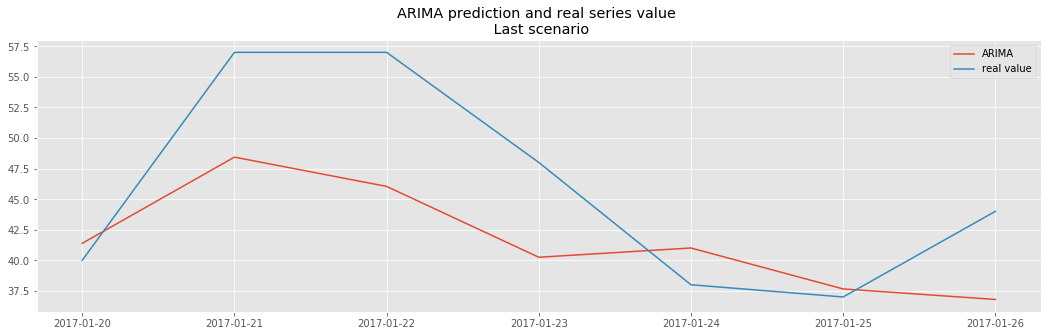

In [52]:
plt.plot(b_model_pred)
plt.plot(cross_val_dict[number_of_validations][1])
plt.legend(["ARIMA", "real value"])
plt.title("ARIMA prediction and real series value \n Last scenario");

We are now going to check the residuals:

When testing the residuals of an estimated ARIMA model, the degrees of freedom need to be adjusted to reflect the parameter estimation. For example, for an ARIMA(p,0,q) model, the degrees of freedom should be set to h-p-q:

residuals mean: -0.023495426025688344
Ljung-Box test results:

Ljung-Box test says there are no significant autocorrelations

Shapiro–Wilk test results:
 (0.9324613213539124, 7.812981398988687e-22)
Shapiro–Wilk test indicates the residuals do not follow a Gaussian distribution



(array([ 1.06332945,  2.4143738 ,  2.82931078,  3.34842898,  5.77997886,
         6.08303465,  9.52301377, 16.75620068]),
 array([0.30245704, 0.29903732, 0.41869754, 0.50129587, 0.32822004,
        0.41395312, 0.21725281, 0.03275027]))

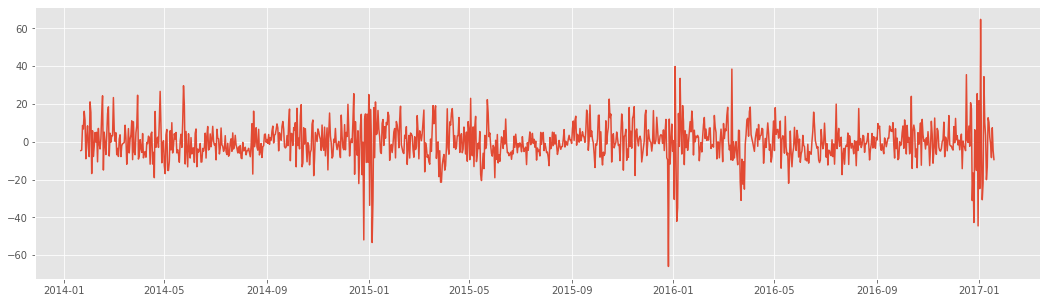

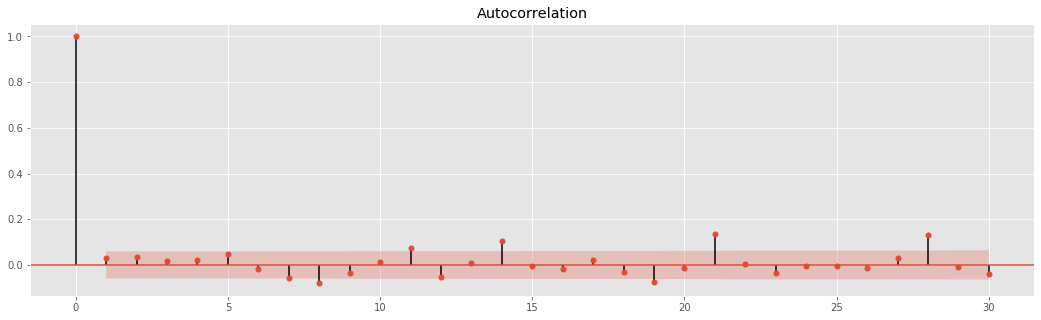

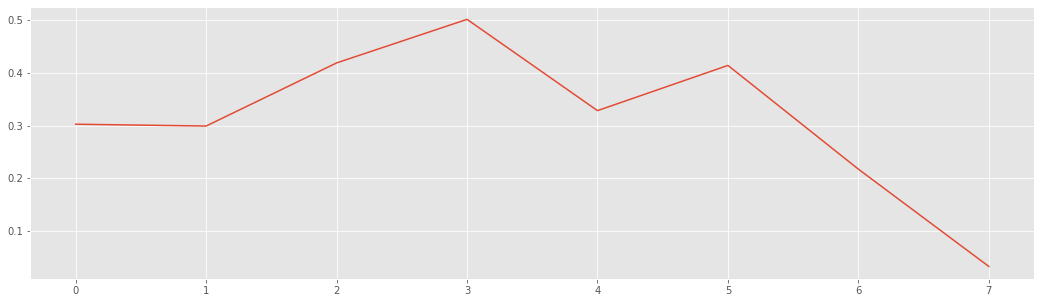

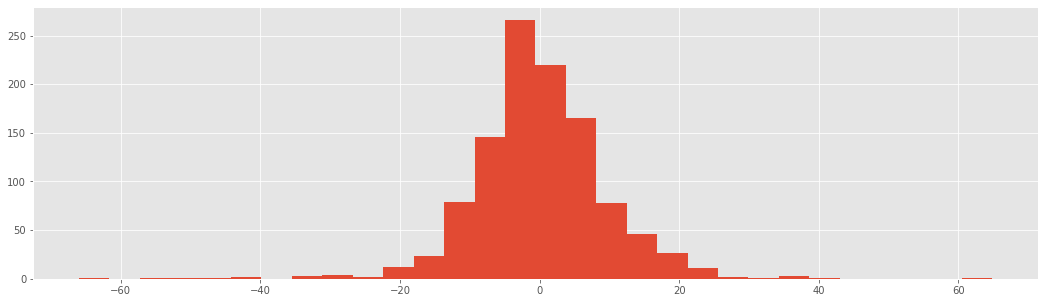

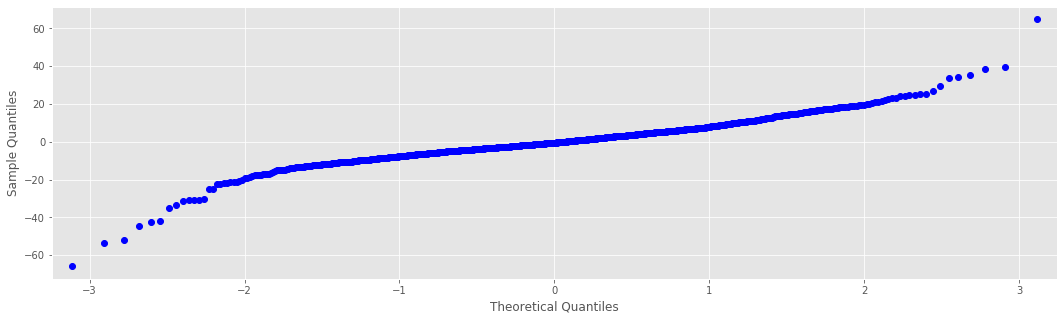

In [53]:
residual_checking(b_model_res, lbtlags=8)

As we can see from running the tests:
    
The mean value is close to zero.

The Ljung-Box test indicates that there are not any significant autocorrelations to exploit, and actually the acf of the residuals indicate no correlations at all.

On the other hand:
    
Again, both the Q-Q plot (such a flat shape indicates heavy tails) and the Shapiro–Wilk test indicates that the distribution is not normal, and the variance doesn't seem to be constant (although more careful checks should be done in this sense).

In [54]:
mse_all_models["ARIMA"] = b_mean_mse_ARIMA

### 2.1.3) SARIMA<a id='a213'></a>

As we have seen, the traditional ARIMA method has worked out for us in the line of the exponential smoothing methods, but slightly worse.

We have to take into consideration that classical ARIMA methods doesn't allow us to handle seasonality in our data.

That's the reason that we have had to use up to 7 lags to get a decent MSE score.

We could have used other methods to handle this seasonality, such as applying the ARIMA to the series differenced with its 7th lag (series.diff(7)), for intance, but that has the inconvenience of having to undo changes manually later.

(By the way, this would be also one of the ways of handling the yearly seasonality that we found in our data and are currently not exploiting).

But the battery of ARIMA methods provides us with a different tool: for handling seasonality, we have the Seasonal ARIMA methods, or SARIMA.

Python provides us the SARIMAX tool, which is a mix of the SARIMA and ARIMAX methods, and that not only allows us to handle seasonality but also introducing external data for studying correlations between SARIMA residuals and the data introduced.

We are going to try it out now, and check wether any improvement from the traditional ARIMA occurs:

In [55]:
data = cross_val_dict[number_of_validations-1]
train = data[0]
test = data[1]

Having now the possibility of handling seasonality appart allows us a greater flexibility in the use of the model.

As we can see from the pacf:

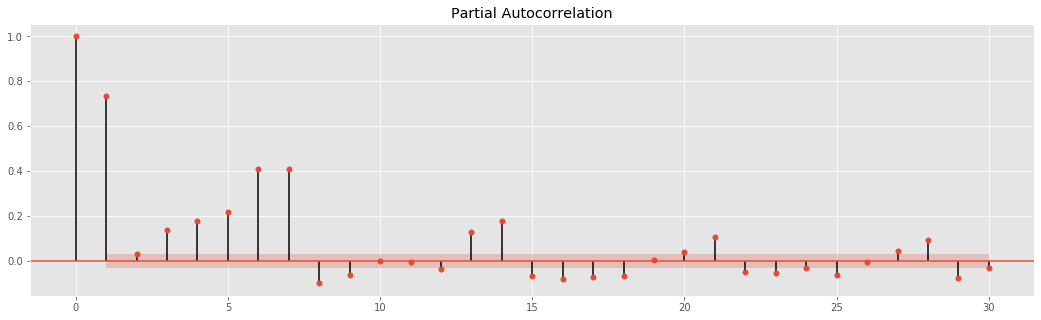

In [56]:
plot_pacf(series, lags=30);

An acceptable model could be designed with an (1,1,0) or (1,1,1) coefficients for the ARIMA and a $(1,1,0)_7$ or $(1,1,1)_7$ for the seasonal part.

We would be paying attention then only to lags 1 and 7, skipping the rest (what would lead us to a simpler, nicer and less demanding numerically program).

The presence of the spikes at lags 3,4,5 and specially, 6, undermines our confidence in such models, and would probably drag the performance of such a model.

So, the optimal model would probably be a (6,1,0) or (6,1,1) with a $(1,1,0)_7$ or $(1,1,1)_7$ for the seasonal part.

We probably will have to keep all the lags up to the 7th and then, there will be no gain in simplicity.

But, perhaps, we can expect even then, small gains in behaviour (checked through the MSE) via the gained flexibility in handling the seasonality appart.

In [57]:
Sorders=(((0,0,0),(0,0,0,7)),
        ((0,0,0),(1,0,0,7)),
        ((1,0,0),(1,0,0,7)),
        ((1,0,0),(1,1,0,7)),
        ((1,1,0),(1,1,0,7)),
        ((1,1,0),(1,1,1,7)),
        ((1,1,1),(1,1,1,7)),
        ((1,1,1),(2,1,1,7)),
        ((2,1,0),(1,1,1,7)),
        ((2,1,1),(1,1,1,7)),
        ((3,0,1),(1,1,1,7)),
        ((3,1,1),(1,1,1,7)),
        ((4,1,1),(1,1,0,7)),
        ((4,1,1),(1,1,1,7)),
        ((5,0,1),(1,1,1,7)),
        ((5,1,1),(1,0,1,7)),
        ((5,1,1),(1,1,0,7)),
        ((5,1,1),(1,1,1,7)),
        ((6,0,0),(0,0,0,7)),
        ((6,0,0),(1,0,0,7)),
        ((6,0,0),(0,1,0,7)),
        ((6,1,0),(0,0,0,7)),
        ((6,1,0),(1,0,0,7)),
        ((6,1,0),(1,1,0,7)),
        ((6,1,0),(1,1,0,7)),
        ((6,1,1),(1,1,0,7)),
        ((6,1,0),(1,1,1,7)),
        ((6,1,1),(1,1,1,7)),
        ((6,0,0),(2,0,0,7)),
        ((6,0,0),(2,1,0,7)),
        ((6,1,0),(2,0,0,7)),
        ((6,1,0),(2,1,0,7)),
        ((6,1,0),(2,1,1,7)),
        ((6,1,1),(2,1,0,7)),
        ((6,1,1),(2,1,1,7)),
)

In [58]:
len(Sorders)

35

Now, we rebuild the ARIMA function for the SARIMAX case, indicating the need for the seasonal order:

In [59]:
# evaluate an SARIMAX model:

def eval_sarimax_model(order, seas_order, train , test):
    
    # Making sure that what the model reveives is a tuple:
    
    order=tuple(order)
    seas_order = tuple(seas_order)
    
    # Creatting and fitting the model:

    model = SARIMAX(train, order=order, seasonal_order=seas_order, trend='t')
    model_fit = model.fit()
    
    # Storing results:
    
    model_summary = model_fit.summary

    model_resid = model_fit.resid
    model_aic = model_fit.aic
    
    model_fitted = model_fit.fittedvalues
    
    # Storing prediction:
    
    # The if-else clause is needed because the predict method requires to indicate how yo need your result in case
    # a model with differences is applied, but, on the other hand, doesn't handle the typ parameter when the model
    # works directly wiith the original series:
    

    model_prediction = model_fit.predict(start = test.index[0], end = test.index[-1])


    # Calculate out of sample error:
    
    model_error = mean_squared_error(test, model_prediction)
    
    # Returning the values:
    
    return model_summary, model_prediction, model_resid, model_aic, model_error, model_fitted

And, consequently, the function for trying out different orders:

In [60]:
# evaluate combinations of p, d and q values for an SARIMAX model

def evaluate_SARIMAX(orders, cross_val_dict):

    # Initializing variables:
    
    model_summ, model_pred, model_res, model_aic, model_error  = None, None, None, None, float("inf")
    b_model_summ, b_model_pred, b_model_res, b_mean_SARIMAX_aic, b_mean_mse_SARIMAX = None, None, None, None, float("inf")
    
    b_mean_mse_series_SARIMAX = None
    b_order = None
    b_seas_order = None   
    
    # as in previous cases, we want to evaluate our errors on average, 
    #so we run our process several times to get mean values:

    for order, seas_order in orders:
        
        # This is a loop control variable that exits all iterations over our test data if the model could not be fitted
        # for any of them:
        
        control=1
        
        mean_mse_SARIMAX, mean_SARIMAX_aic = 0, 0
        mean_mse_series_SARIMAX = np.array([0.0]*horizon)
        
        for key, data in cross_val_dict.items():
    
            train = data[0]
            test = data[1]
            
            # tries to apply the eval_SARIMAX_model function with the order indicated.
            # if it does cannot apply it (because of irreversibility on the initial coefficients), prints a warning and breaks
            
            try:
                model_summ, model_pred, model_res, model_aic, model_error, model_fitted = eval_sarimax_model(order, seas_order, train, test)
#                 print(order, key)
                
            except:
                print("SARIMAX ", order,",", seas_order," model could not be fitted for ", " test data nr. ", key)
                control=0
                continue
                
            # Aggregating the results for the current loop to the squared errors series, the total error and the aic
            # of our model:

            squared_dif_series = (model_pred - test)**2

            mean_mse_SARIMAX += model_error
            mean_SARIMAX_aic += model_aic

            mean_mse_series_SARIMAX += np.array(squared_dif_series)
            
        # After all iterations, we divide by the number of validations to obtain mean values:

        mean_mse_SARIMAX = mean_mse_SARIMAX/number_of_validations
        mean_SARIMAX_aic = mean_SARIMAX_aic/number_of_validations
        mean_mse_series_SARIMAX=pd.Series(mean_mse_series_SARIMAX/horizon)
        
        # Now we store the values of the best model (in terms of MSE):

        if (mean_mse_SARIMAX < b_mean_mse_SARIMAX) & control==1:
            
            b_mean_mse_SARIMAX = mean_mse_SARIMAX
            b_mean_SARIMAX_aic = mean_SARIMAX_aic
            b_mean_mse_series_SARIMAX = mean_mse_series_SARIMAX

            b_model_summ, b_model_pred, b_model_res = model_summ, model_pred, model_res
            
            b_order = order
            b_seas_order = seas_order
            
        # Printing out average error values for the current model:

        print('SARIMAX %s, %s MSE=%s AIC=%s' % (order, seas_order, mean_mse_SARIMAX, mean_SARIMAX_aic))
        
    # Printing out average error values for the best model:
                    
    print('Best SARIMAX %s, %s MSE=%s AIC=%s' % (b_order, b_seas_order, b_mean_mse_SARIMAX, b_mean_SARIMAX_aic))
    
    # Returning the data of the best model:
    
    return b_model_summ, b_model_pred, b_model_res, b_mean_SARIMAX_aic, b_mean_mse_SARIMAX, b_mean_mse_series_SARIMAX

And now, we launch our function for trying out all our orders:

In [61]:
b_SARIMAX_summ, b_SARIMAX_pred, b_SARIMAX_res, b_SARIMAX_ARIMA_aic, b_mean_mse_SARIMAX, b_mean_mse_series_SARIMAX = evaluate_SARIMAX(Sorders, cross_val_dict)

SARIMAX (0, 0, 0), (0, 0, 0, 7) MSE=615.0929307422672 AIC=10443.740738654931
SARIMAX (0, 0, 0), (1, 0, 0, 7) MSE=70.85208622698423 AIC=8498.894437258667
SARIMAX (1, 0, 0), (1, 0, 0, 7) MSE=90.35171688747505 AIC=8312.590171781307
SARIMAX (1, 0, 0), (1, 1, 0, 7) MSE=53.07149228869635 AIC=8159.92015159109
SARIMAX (1, 1, 0), (1, 1, 0, 7) MSE=156.05959545563076 AIC=8393.99035487973
SARIMAX (1, 1, 0), (1, 1, 1, 7) MSE=145.8806064571858 AIC=8154.878566571308
SARIMAX (1, 1, 1), (1, 1, 1, 7) MSE=68.39370260475384 AIC=8130.769201940777
SARIMAX (1, 1, 1), (2, 1, 1, 7) MSE=64.10837616778693 AIC=8114.50711047686
SARIMAX (2, 1, 0), (1, 1, 1, 7) MSE=110.67007371862155 AIC=8098.005191935529
SARIMAX  (2, 1, 1) , (1, 1, 1, 7)  model could not be fitted for   test data nr.  6
SARIMAX  (2, 1, 1) , (1, 1, 1, 7)  model could not be fitted for   test data nr.  7
SARIMAX  (2, 1, 1) , (1, 1, 1, 7)  model could not be fitted for   test data nr.  8
SARIMAX  (2, 1, 1) , (1, 1, 1, 7)  model could not be fitted for

As we can see, we experience a sharp gain (our error has been reduced in about a 25%) in precission by using a SARIMA instead of an ARIMA, for the SARIMAX (6, 1, 0), (2, 1, 1, 7) (MSE=42.9077150377296, AIC=2379.2421006519226).

We want also to remark that the simpler SARIMAX (1, 1, 1), (1, 1, 1, 7) has presented a better than the ARIMA(7,1,1) results, the best of our ARIMA, using less information.

So, by handling seasonality appart, we have experienced a huge gain.

We would also like to underscore that now, this model performs better than the Holt-Winters that we tried out above.

That are all the perks of handling seasonality appart.

Let's plot the series for the last scenario for our best model:

Text(0.5, 1.0, 'SARIMA prediction and real series value \n Last scenario')

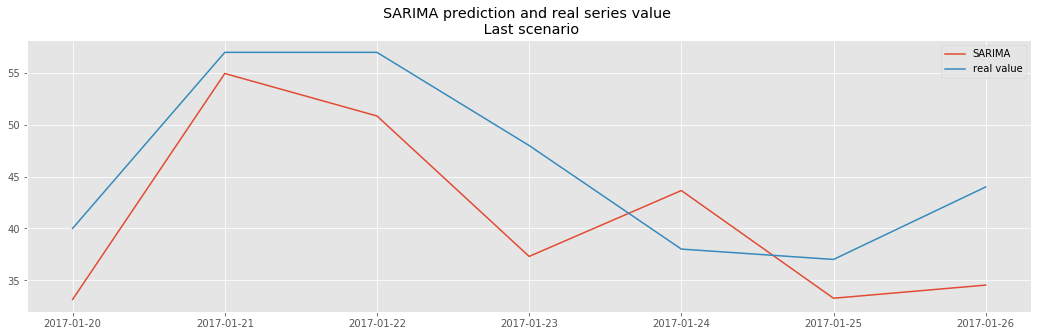

In [62]:
plt.plot(b_SARIMAX_pred)
plt.plot(cross_val_dict[number_of_validations][1])
plt.legend(["SARIMA", "real value"])
plt.title("SARIMA prediction and real series value \n Last scenario")

residuals mean: 0.3103974858202745
Ljung-Box test results:

Ljung-Box test says there are still some significant autocorrelations
Shapiro–Wilk test results:
 (0.8706519603729248, 3.7532260950116637e-29)
Shapiro–Wilk test indicates the residuals do not follow a Gaussian distribution



(array([12.00602148, 38.08460229, 39.6800139 , 59.03721403, 88.73901383]),
 array([5.30289385e-04, 5.37073457e-09, 1.24560039e-08, 4.62164482e-12,
        1.23639268e-17]))

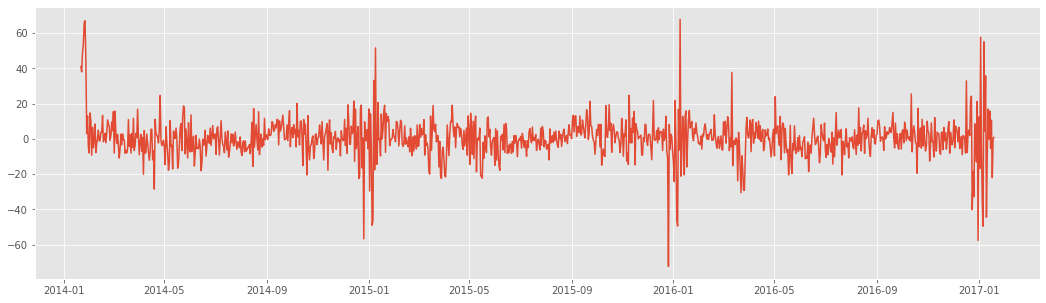

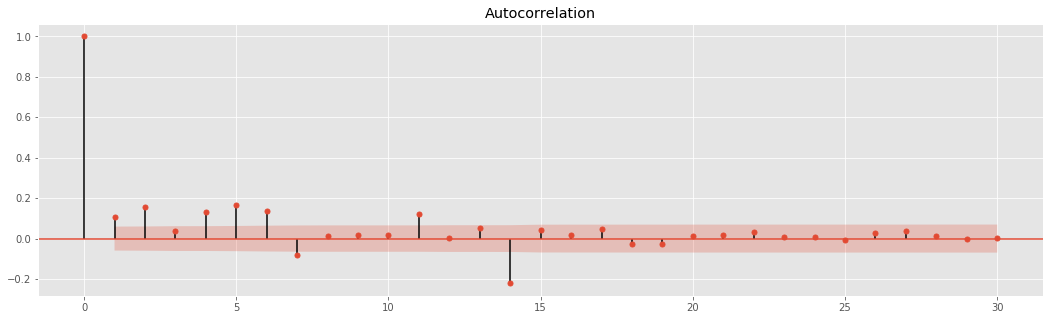

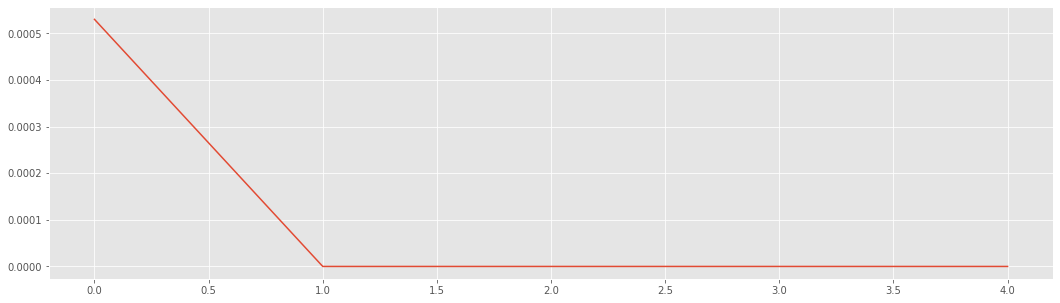

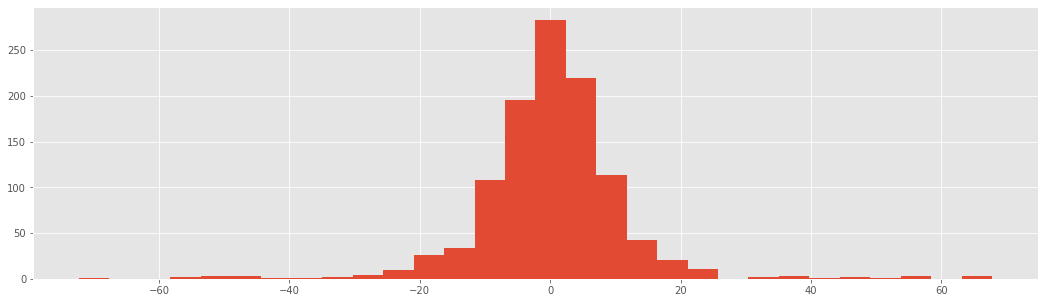

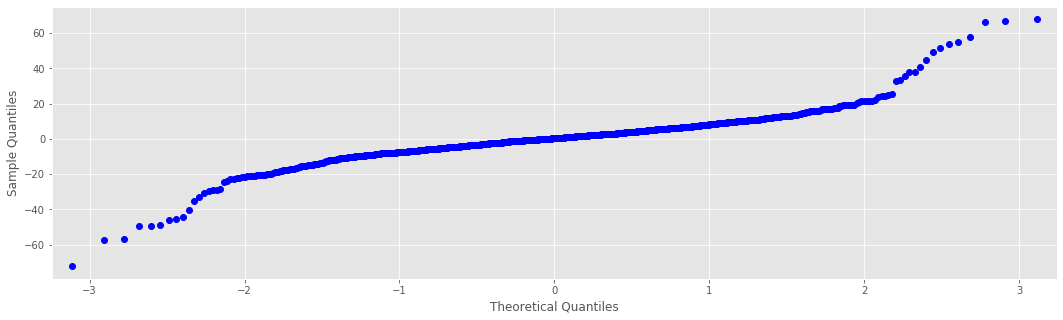

In [63]:
residual_checking(b_SARIMAX_res, lbtlags=5)

As we can see again:
    
The mean value is close to zero.

As with the ARIMA model, the Ljung-Box test indicates that there are not any significant autocorrelations to exploit, in the same line to what the acf shows us.

On the other hand:
    
Both the Q-Q plot (such a flat shape indicates heavy tails) and the Shapiro–Wilk test indicates that the distribution is not normal, and the variance doesn't seem to be constant (although more careful checks should be done in this sense).

In [64]:
mse_all_models["SARIMA"] = b_mean_mse_SARIMAX

### 2.1.4) PROPHET<a id='a214'></a>

We want now to compare the results of the classical methods used, against a time series tool developed by Facebook data scientists: Prophet.
    
*"Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.*

*Prophet is open source software released by Facebook’s Core Data Science team."*

Source: https://facebook.github.io/prophet/

As in previous cases, we try it out with just the last series of those defined:

In [65]:
data = cross_val_dict[number_of_validations-1]
train = data[0]
test = data[1]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE Prophet: 62.65872972736259


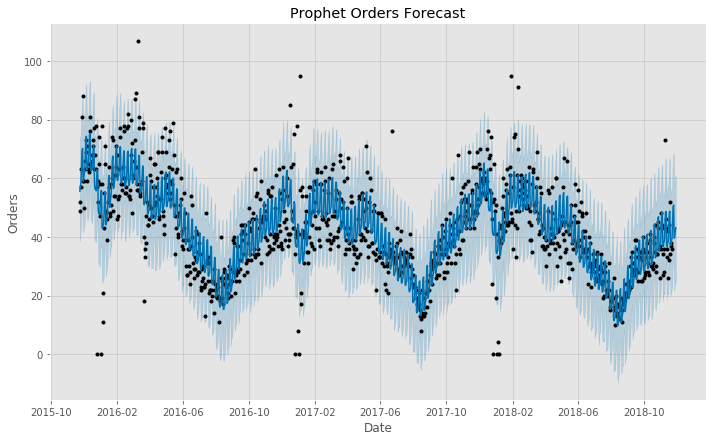

In [66]:
train_for_prophet = train.reset_index()
train_for_prophet = train_for_prophet.rename(columns={'order_date': 'ds', 'units_ordered': 'y'})

prophet_model = Prophet(interval_width=0.95)
prophet_model = prophet_model.fit(train_for_prophet)

prophet_series = prophet_model.make_future_dataframe(periods=7, freq='D')
prophet_prediction = prophet_model.predict(prophet_series)

# plt.figure(figsize=(18, 6))
prophet_model.plot(prophet_prediction, xlabel = 'Date', ylabel = 'Orders')
plt.title('Prophet Orders Forecast')

test_for_prophet = test.reset_index()
test_for_prophet = test_for_prophet.rename(columns={'order_date': 'ds', 'units_ordered': 'y'})
predictions = prophet_model.predict(test_for_prophet)

mse_prophet = mean_squared_error(test_for_prophet["y"], predictions["yhat"])
print("MSE Prophet:", mse_prophet)

In [67]:
def eval_prophet(train, test):  
    
    train_for_prophet = train.reset_index()
    train_for_prophet = train_for_prophet.rename(columns={'order_date': 'ds', 'units_ordered': 'y'})
    test_for_prophet = test.reset_index()
    test_for_prophet = test_for_prophet.rename(columns={'order_date': 'ds', 'units_ordered': 'y'})

    prophet_model = Prophet(interval_width=0.95, yearly_seasonality = True, weekly_seasonality = True)
    prophet_model = prophet_model.fit(train_for_prophet)
    
    predictions = prophet_model.predict(test_for_prophet)
    
    prophet_series = prophet_model.make_future_dataframe(periods=0, freq='D')
    prophet_fitted_val = prophet_model.predict(prophet_series)["yhat"]
    
    res_prophet = train_for_prophet['y'] - prophet_model.predict(prophet_series)["yhat"]

    squared_dif_series = (test_for_prophet["y"] - predictions["yhat"])**2
    
    return prophet_fitted_val, prophet_series, predictions, res_prophet, squared_dif_series, mse_prophet

Now, we are ready to try it out, as the rest of our procesures, for all the values, so we can calculate an average value of its performance:

In [68]:
mean_mse_prophet = 0
mean_mse_series_prophet = np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]
    
    prophet_series, dates, predictions, res_prophet, squared_dif_series, mse_prophet = eval_prophet(train, test)

    mean_mse_prophet += (squared_dif_series).mean()   
    mean_mse_series_prophet += np.array(squared_dif_series)
    
    print("MSE:", (squared_dif_series).mean())

mean_mse_prophet = mean_mse_prophet/number_of_validations
mean_mse_series_prophet = pd.Series(mean_mse_series_prophet/horizon)

print("mean MSE:", mean_mse_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 54.73985364602469


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 40.97725871065448


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 32.97419883100763


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 50.14180857536373


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 25.682001837399724


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 77.76496773940266


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 182.18682474993537


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 77.55487162416567


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 62.65872972736259
MSE: 22.268180492753032
mean MSE: 62.69486959340695


As we can see, the Prophet models work out a nice, low error in the range of the best of our previous models: the SARIMA, indicating that the library is powerful enough for using it without any worries and yielding good forecasts, as their authors claim.

Let's plot the model predicted values for our last series and its errors, compared to those of the rest of our models:

Text(0.5, 1.0, 'Prophet prediction and real series value \n Last scenario')

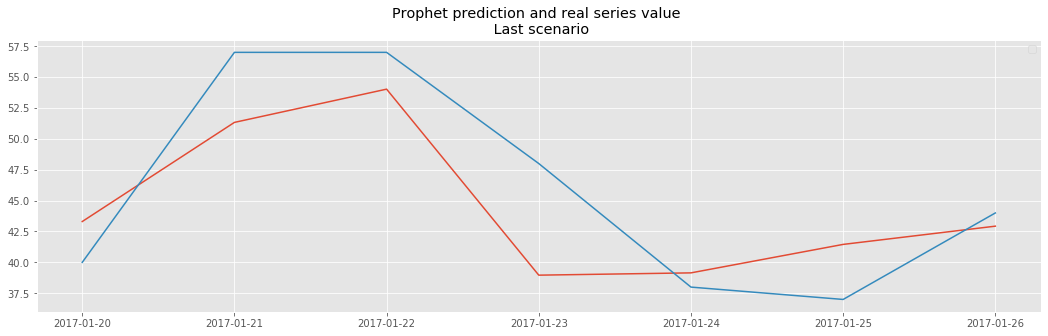

In [69]:
plt.plot(predictions['ds'],predictions["yhat"])
plt.plot(test)
plt.legend("Prophet", "real value")
plt.title("Prophet prediction and real series value \n Last scenario")

Now, let's check the residuals:

residuals mean: -0.002664404269454373
Ljung-Box test results:

Ljung-Box test says there are still some significant autocorrelations
Shapiro–Wilk test results:
 (0.928029477596283, 1.6847466325622307e-22)
Shapiro–Wilk test indicates the residuals do not follow a Gaussian distribution



(array([ 86.47698484,  87.60420268,  96.10268952,  96.48994929,
        102.00916663, 131.66778325, 195.29057516, 197.80489145,
        199.52709324, 203.37200518, 203.57759839, 203.61454587,
        215.57273566, 239.25760073]),
 array([1.41373031e-20, 9.48394642e-20, 1.06985399e-20, 5.49332951e-20,
        1.99286090e-20, 5.72485995e-26, 1.13995846e-38, 1.85319910e-38,
        4.16244947e-38, 3.19458342e-38, 1.34559511e-37, 5.84816969e-37,
        8.53845457e-39, 4.76105617e-43]))

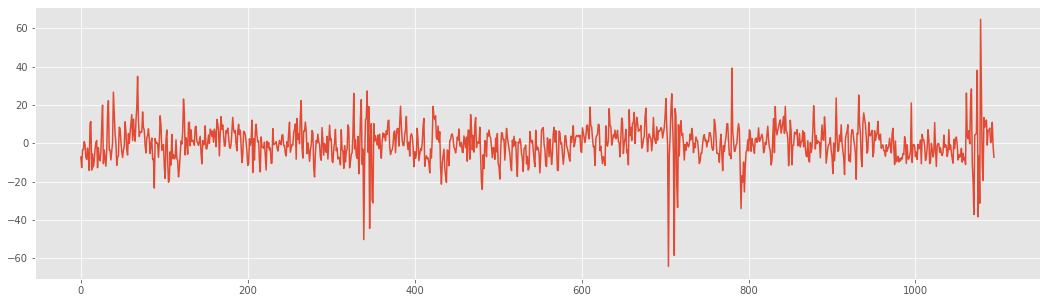

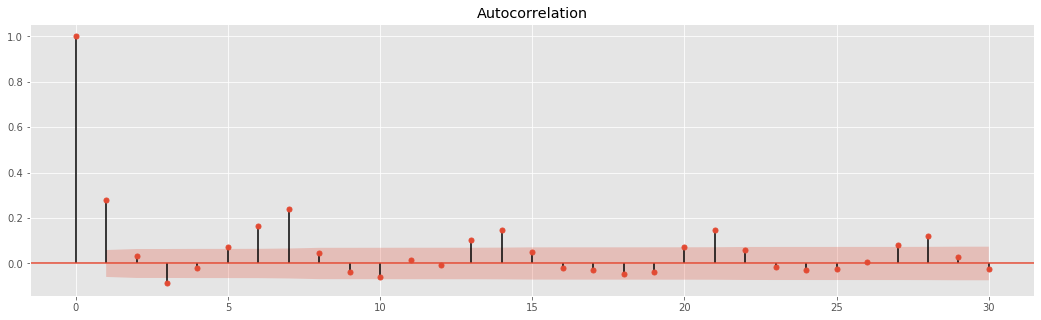

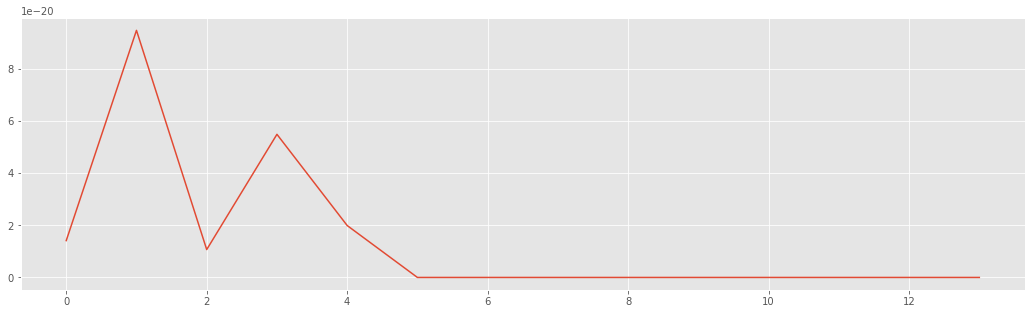

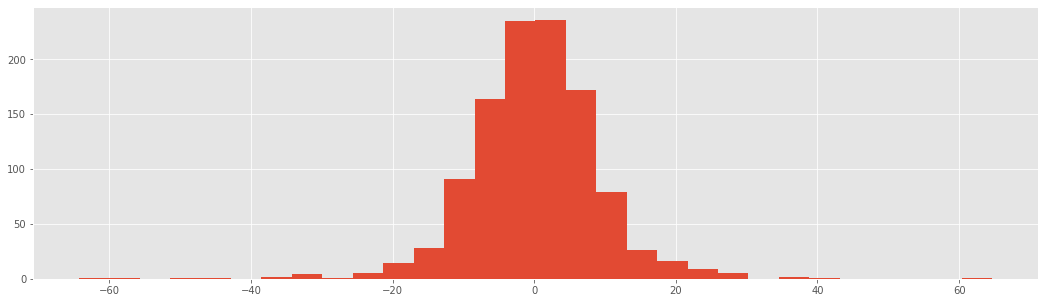

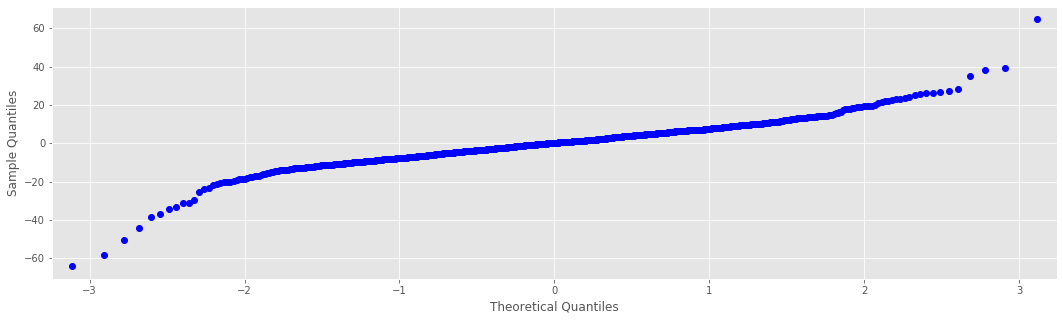

In [70]:
residual_checking(res_prophet)

As we can see from running the tests:

The mean value is close to zero.

The Ljung-Box test indicates that there are still some significant autocorrelations to exploit, and actually the acf of the residuals indicate some moderate autocorrelations for lags 1 and 7, now noticeably appart from the line of the 5% chance of possibility of having been produced by chance.

On the other hand:

Both the Q-Q plot (such a flat shape indicates heavy tails) and the Shapiro–Wilk test indicates that the distribution is not normal, and the variance doesn't seem to be constant (although more careful checks should be done in this sense).

Again, this is a property of our data, and not such of the model.

In [71]:
mse_all_models["Prophet"] = mean_mse_prophet

### 2.2.) MACHINE LEARNING<a id='a22'></a>

### 2.2.1.) RANDOM FOREST
 
Let's now try a random forest with only the time series as input. The steps we will need to follow are:
 
1. Transform the data: each row should contain the features (previous days, matches, etc)
2. Fit the model and predict
4. Evaluate the error
 
Before starting, we want to comment a particularity of forecasting with Machine Learning techniques: as we know, Machine Learning techniques are based in finding relationships between a variable and one or many inputs, the features. The problem when applying this techniques to time series, is that any particular model would trained and, so, able to provide, just one prediction.
 
As it is explained, among others, in *"Machine Learning Strategies for Time Series Forecasting"*, by Gianluca Bontempi, Souhaib Ben Taieb and Yann-Aël Le Borgne, there are several strategies to solve this inconvenience: https://link.springer.com/chapter/10.1007/978-3-642-36318-4_3
 
As we can see, there are two main approaches when dealing with this problem:
 
1) The direct approach, in which we train one model for each prediction
 
2) The recursive strategy, in which we train one model, and to this model we feed its previous predictions as if they were data, to get other predictions ahead in time
 
Of course, taking these two strategies as an starting point, mixed methods have also arisen.
 
For predicting we are going to use a direct strategy, creating a model for each prediction, and not a recursive strategy. This is because of the following reasons:
 
1) A direct strategy is simpler both to implement and when evaluating its results.
 
2) In any recursive strategy, as we are using predicted values as if they were the real ones, the error commited is accumulative, resulting in an aggregated scalation of error.

### Creating the function that rearranges the data:

Lets start creating the function that will transform the data, which was adapted from the following site: https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/
 
Our function takes in the series, the number of lags needed, and the number of steps ahead that we want to go for our prediction, and arranges the data in the series in a convenient manner to fit our purposes:

In [72]:
data = cross_val_dict[number_of_validations-1]
train = data[0]
test = data[1]

In [73]:
def data_transformation(series, n_lag, lead_time):
    """ Takes a series, a number of lag observations to use as input, 
    and a forecast lead time to predict, then will return a list of input/out 
    rows drawn from the series """

    data = list()
    # enumerate observations and create input/output patterns

    
    for i in range(n_lag, len(series)-max(lead_time)+1):
        
        end_ix=list()
        
        for lead in lead_time:
            ei = i + (lead - 1)
            end_ix.append(ei)
            
            # check if can create a pattern
            if ei >= len(series)-1:
                break
#         print(i, end_ix)
        
        # retrieve input and output
        start_ix = i - n_lag
        
        to_be_predicted = list()
        
        for element in end_ix:
            to_be_predicted.append(series[element])
        
        row = series[start_ix:i] + to_be_predicted
        data.append(row)
        
    return list(data)

In [74]:
aaa = ["a" + str(a) for a in range(20)]

In [75]:
data_transformation(aaa,7,[1,3,5,7])

[['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a9', 'a11', 'a13'],
 ['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a10', 'a12', 'a14'],
 ['a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a11', 'a13', 'a15'],
 ['a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a12', 'a14', 'a16'],
 ['a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a13', 'a15', 'a17'],
 ['a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a14', 'a16', 'a18'],
 ['a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a15', 'a17', 'a19']]

It is important to note that in order to transform the data we need to provide the function with the previous number of days that we want to consider for the prediction, as well as the gap between the prediction and the data:

In [76]:
# Take into account the las 365 days
previous_days = 10

# Selecting the days to forecast
to_be_predicted = [1,2,3,4,5,6,7]

# Creating the column names for the dataframe
colnames_past = ['past' + str(previous_days - i) for i in range(previous_days)]
colnames_to_pred = ['to_pred' + str(i) for i in to_be_predicted]
# colnames_to_pred = ["to_pred"]

colnames = colnames_past  + colnames_to_pred

# Creating the slicer for the index of our dataframe
inf_index = max(to_be_predicted) + previous_days - 1

In [77]:
#Required by data_transformation
train_list = list(train)

test_n = train[len(train)-previous_days:].append(test)
test_list = list(test_n)

#Lets keep the index
index_train = train.index
index_test = test.index

#Transform test and train and keeps the 
train_rf = pd.DataFrame(data_transformation(train_list, previous_days, to_be_predicted), index = index_train[inf_index:], columns = colnames)
test_rf = pd.DataFrame(data_transformation(test_list, previous_days, to_be_predicted), columns = colnames)

In [78]:
test_rf

,past10,past9,past8,past7,past6,past5,past4,past3,past2,past1,to_pred1,to_pred2,to_pred3,to_pred4,to_pred5,to_pred6,to_pred7
0,33.0,42.0,26.0,32.0,44.0,52.0,34.0,38.0,37.0,36.0,42.0,61.0,58.0,35.0,33.0,29.0,39.0


In [79]:
RF_model_storage = list()

RandomFor_pred = np.array([0]*len(colnames_to_pred))
squared_error_distribution = np.array([0]*len(colnames_to_pred))

for i, column in enumerate(colnames_to_pred):

    # Create random forest object
    clf = RandomForestRegressor(max_depth=4)

    # Split the features form the target variable
    X_train = train_rf[colnames_past]
    y_train = train_rf[column]

    # Train the model
    RF_model = clf.fit(X_train,y_train)
    
    RF_model_storage.append(RF_model)

    X_test = test_rf[colnames_past]
    y_test = test_rf[column]

    # Making the prediction
    RF_pred = clf.predict(X_test)
    RandomFor_pred[i] = RF_pred

    # Calculate the error
    mse = mean_squared_error(RF_pred, y_test)
    squared_error_distribution[i] = mse

print(RandomFor_pred)
print(squared_error_distribution)

squared_error_distribution.mean()

[36 44 46 35 37 35 34]
[ 27 264 137   0  19  47  22]


73.71428571428571

Let's plot our results:

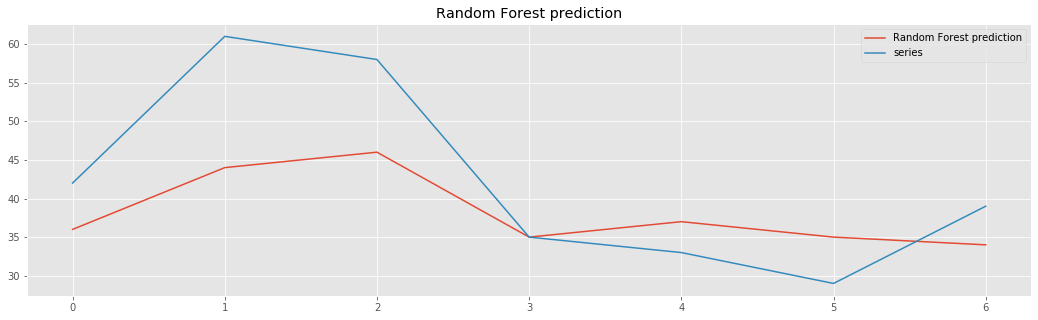

In [80]:
plt.plot(RandomFor_pred)
plt.plot(np.array(test))
plt.legend(["Random Forest prediction", "series"])
plt.title("Random Forest prediction");

Let's now define a function that does all the work for us:

In [81]:
def function_random_forest_models(train, test, previous_days, to_be_predicted):

    # Creating the column names for the dataframe
    colnames_past = ['past' + str(previous_days - i) for i in range(previous_days)]
    colnames_to_pred = ['to_pred' + str(i) for i in to_be_predicted]
    # colnames_to_pred = ["to_pred"]

    colnames = colnames_past  + colnames_to_pred

    # Creating the slicer for the index of our dataframe
    inf_index = max(to_be_predicted) + previous_days - 1

    #Required by data_transformation
    train_list = list(train)

    test_n = train[len(train)-previous_days:].append(test)
    test_list = list(test_n)

    #Lets keep the index
    index_train = train.index
    index_test = test.index

    #Transform test and train and keeps the 
    train_rf = pd.DataFrame(data_transformation(train_list, previous_days, to_be_predicted), index = index_train[inf_index:], columns = colnames)
    test_rf = pd.DataFrame(data_transformation(test_list, previous_days, to_be_predicted), columns = colnames)

    RF_model_storage = list()

    RandomFor_pred = np.array([0]*len(colnames_to_pred))
    squared_error_distribution = np.array([0]*len(colnames_to_pred))

    for i, column in enumerate(colnames_to_pred):

        # Create random forest object
        clf = RandomForestRegressor(max_depth=4)

        # Split the features form the target variable
        X_train = train_rf[colnames_past]
        y_train = train_rf[column]

        # Train the model
        RF_model = clf.fit(X_train,y_train)

        RF_model_storage.append(RF_model)

        X_test = test_rf[colnames_past]
        y_test = test_rf[column]

        # Making the prediction
        RF_pred = clf.predict(X_test)
        RandomFor_pred[i] = RF_pred

        # Calculate the error
        mse = mean_squared_error(RF_pred, y_test)
        squared_error_distribution[i] = mse

    print("The MSE is:", squared_error_distribution.mean())
    
    return RandomFor_pred, squared_error_distribution, RF_model_storage

We are going to try it out:

In [82]:
# Take into account the las 365 days
previous_days = 14

# Selecting the days to forecast
to_be_predicted = [1,2,3,4,5,6,7]

In [83]:
RF_pred, sqed, RF_model_storage = function_random_forest_models(train, test, previous_days, to_be_predicted)

The MSE is: 72.85714285714286


Now, we are going to plot the resulting model. Remember, that our "model" is in reality a series of 7 different models, each calibrated for an specific leap:

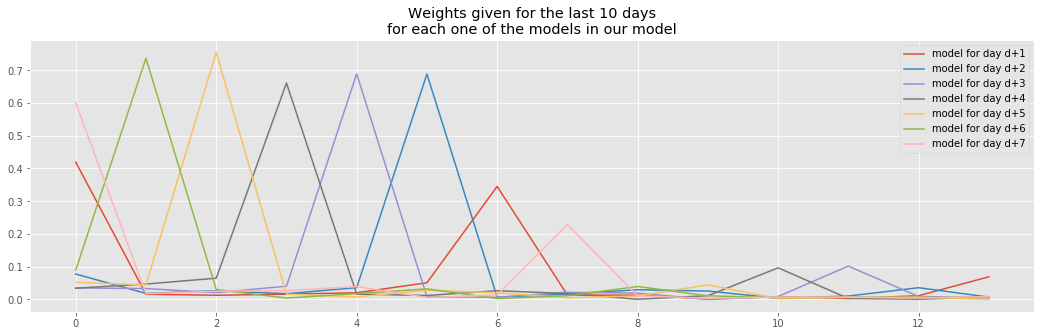

In [84]:
list_for_legend = ["model for day d+" + str(i+1) for i in range(len(RF_model_storage))]
range(14,0)

for i,element in enumerate(RF_model_storage):
    arr = element.feature_importances_
    reversed_arr = arr[::-1]
    reversed_arr
    plt.plot(reversed_arr)

plt.legend(list_for_legend)
plt.title("Weights given for the last 10 days\nfor each one of the models in our model");

As we can see, for the model predicting the first leap forward (day d+1), the two positions with the most weight are day 0 and day -6 (in terms of day d+1, those correspond to lags 1 and 7).

This behaviour is coherent to what we found in earlier models.

We can also see that for each other day d+n prediction, the coefficient with the most weight happens to be it's lag 7 equivalent, what it is also consistent.

However, for the rest of the days we loose the reference lag 1, because the series takes the last 14 values to forecast the next 7, so, for it's second forecast, the actual value of day d+1 would be needed, but that information is not available at the time the forecast is done.

We can see that the model ammends that lack of information giving more weight to the lag 7 for model 2 to 7, when comparing them to the first model.

Because of the absence of the information of the lag 1, for models 2 to 7 we could expect, then, a much worse prediction, than for our first model.

Also, as we loose the reference of lag 1 for 6 out of 7 of our predictions, we can expect a much worse behaviour from the models from day d+2 to d+7 than the behaviour resulting from our time series models, resulting in a ballast for this approach that should make its MSE go higher than for the rest of the models.

This is what we are going to check next, let's run the random forest for all our scenarios to get the mean value of its MSE:

In [85]:
mean_mse_RF = 0
mean_mse_series_RF =np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    RF_pred, squared_dif_series, RF_model_storage = function_random_forest_models(train, test, previous_days, to_be_predicted)
    
    mean_mse_RF += (squared_dif_series).mean()
    
    mean_mse_series_RF += np.array(squared_dif_series)

mean_mse_RF = mean_mse_RF/number_of_validations
mean_mse_series_RF = pd.Series(mean_mse_series_RF/horizon)

print("mean MSE:", mean_mse_RF)

The MSE is: 79.0
The MSE is: 10.714285714285714
The MSE is: 49.714285714285715
The MSE is: 124.0
The MSE is: 8.571428571428571
The MSE is: 60.142857142857146
The MSE is: 6.428571428571429
The MSE is: 26.857142857142858
The MSE is: 67.57142857142857
The MSE is: 57.0
mean MSE: 49.0


As we can see, the model has yielded a mean MSE higher than that of the Holt-Winters, ARIMA, SARIMA or Prophet methods.

We are going to plot again the coefficients for our new model, to check if they are in line to what we found in our earlier model.

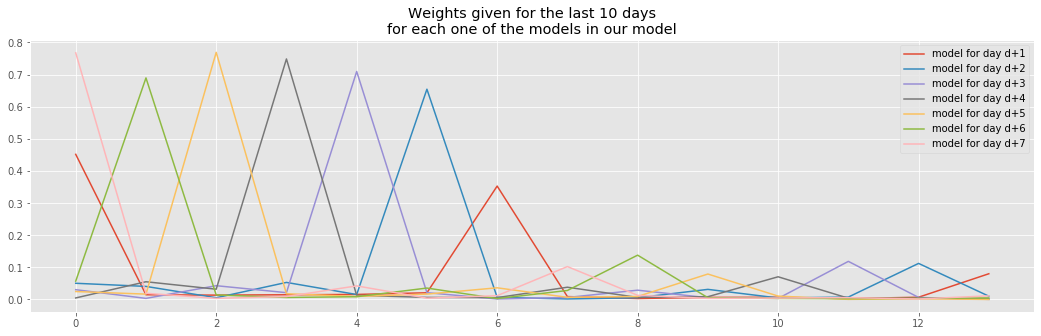

In [86]:
for i,element in enumerate(RF_model_storage):
    arr = element.feature_importances_
    reversed_arr = arr[::-1]
    reversed_arr
    plt.plot(reversed_arr)

plt.legend(list_for_legend)
plt.title("Weights given for the last 10 days\nfor each one of the models in our model");

As we can see, they are: the shape of the distributions has changed slightly, but the same phenomena that occured in our first model happens again here.
    
Let's now check the predictions versus the series, for the last of our series:

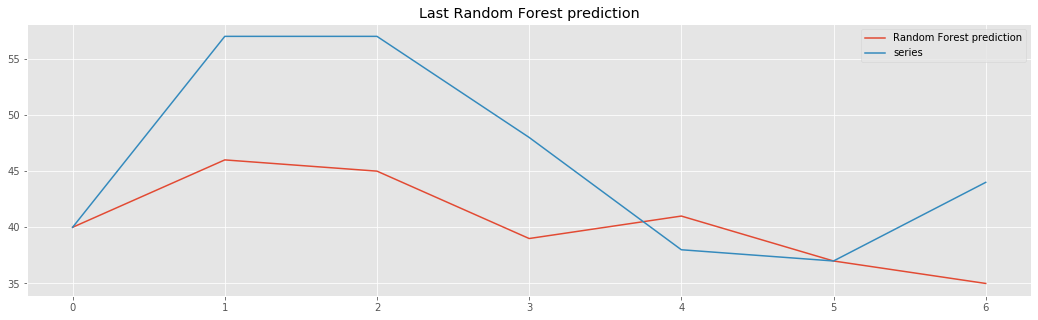

In [87]:
plt.plot(RF_pred)
plt.plot(np.array(test))
plt.legend(["Random Forest prediction", "series"])
plt.title("Last Random Forest prediction");

And, finally, the distribution of our errors:

**Residuals checks:**
    
For this model there is no automatic, easy way of defining residuals, as it consists in a collection of 7 models, each one specialized in a number of leaps forward.

So, trying to fit the model to the series is a complicated matter, as we should before ask the following question: which of the models should be used to fit each of the data points of our series?
    
As one can easlity see, this is a strong inconvenience.

In [88]:
mse_all_models["Random Forest"] = mean_mse_RF

### 2.2.2. MLR

In [89]:
from sklearn.linear_model import LinearRegression

In [90]:
def function_MLR_models(train, test, previous_days, to_be_predicted):

    # Creating the column names for the dataframe
    colnames_past = ['past' + str(previous_days - i) for i in range(previous_days)]
    colnames_to_pred = ['to_pred' + str(i) for i in to_be_predicted]
    # colnames_to_pred = ["to_pred"]

    colnames = colnames_past  + colnames_to_pred

    # Creating the slicer for the index of our dataframe
    inf_index = max(to_be_predicted) + previous_days - 1

    #Required by data_transformation
    train_list = list(train)

    test_n = train[len(train)-previous_days:].append(test)
    test_list = list(test_n)

    #Lets keep the index
    index_train = train.index
    index_test = test.index

    #Transform test and train and keeps the 
    train_MLR = pd.DataFrame(data_transformation(train_list, previous_days, to_be_predicted), index = index_train[inf_index:], columns = colnames)
    test_MLR = pd.DataFrame(data_transformation(test_list, previous_days, to_be_predicted), columns = colnames)

    MLR_model_storage = list()

    RandomFor_pred = np.array([0]*len(colnames_to_pred))
    squared_error_distribution = np.array([0]*len(colnames_to_pred))

    for i, column in enumerate(colnames_to_pred):

        # Create random forest object
        clf = RandomForestRegressor(max_depth=4)

        # Split the features form the target variable
        X_train = train_MLR[colnames_past]
        y_train = train_MLR[column]

        # Train the model
        MLR_model = LinearRegression().fit(X_train,y_train)

        MLR_model_storage.append(MLR_model)

        X_test = test_MLR[colnames_past]
        y_test = test_MLR[column]

        # Making the prediction
        MLR_pred = MLR_model.predict(X_test)
        RandomFor_pred[i] = MLR_pred

        # Calculate the error
        mse = mean_squared_error(MLR_pred, y_test)
        squared_error_distribution[i] = mse

    print("The MSE is:", squared_error_distribution.mean())
    
    return RandomFor_pred, squared_error_distribution, MLR_model_storage

In [91]:
MLR_pred, MLR_sqed, MLR_model_storage = function_MLR_models(train, test, previous_days, to_be_predicted)

The MSE is: 49.857142857142854


In [92]:
mean_mse_MLR = 0
mean_mse_series_MLR =np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    MLR_pred, MLR_sqed, MLR_model_storage = function_MLR_models(train, test, previous_days, to_be_predicted)
    
    mean_mse_MLR += (squared_dif_series).mean()
    
    mean_mse_series_MLR += np.array(squared_dif_series)

mean_mse_MLR = mean_mse_MLR/number_of_validations
mean_mse_series_MLR = pd.Series(mean_mse_series_MLR/horizon)

print("mean MSE:", mean_mse_MLR)

The MSE is: 57.142857142857146
The MSE is: 10.714285714285714
The MSE is: 86.85714285714286
The MSE is: 65.14285714285714
The MSE is: 79.14285714285714
The MSE is: 92.0
The MSE is: 26.857142857142858
The MSE is: 28.428571428571427
The MSE is: 72.0
The MSE is: 49.857142857142854
mean MSE: 57.0


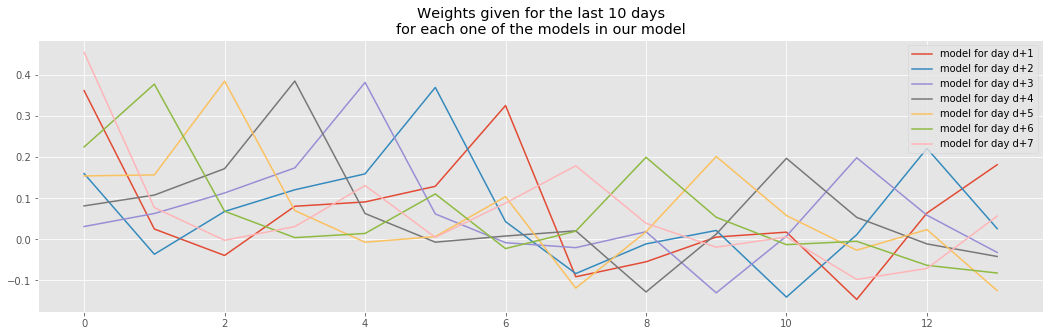

In [93]:
for i,element in enumerate(MLR_model_storage):
    arr = element.coef_
    reversed_arr = arr[::-1]
    reversed_arr
    plt.plot(reversed_arr)

plt.legend(list_for_legend)
plt.title("Weights given for the last 10 days\nfor each one of the models in our model");

In [94]:
mse_all_models["MLR"] = mean_mse_MLR

### 2.2.3. K-Neighbours

In [95]:
from sklearn.neighbors import KNeighborsRegressor

In [105]:
def function_KNN_models(train, test, previous_days, to_be_predicted):

    # Creating the column names for the dataframe
    colnames_past = ['past' + str(previous_days - i) for i in range(previous_days)]
    colnames_to_pred = ['to_pred' + str(i) for i in to_be_predicted]
    # colnames_to_pred = ["to_pred"]

    colnames = colnames_past  + colnames_to_pred

    # Creating the slicer for the index of our dataframe
    inf_index = max(to_be_predicted) + previous_days - 1

    #Required by data_transformation
    train_list = list(train)

    test_n = train[len(train)-previous_days:].append(test)
    test_list = list(test_n)

    #Lets keep the index
    index_train = train.index
    index_test = test.index

    #Transform test and train and keeps the 
    train_KNN = pd.DataFrame(data_transformation(train_list, previous_days, to_be_predicted), index = index_train[inf_index:], columns = colnames)
    test_KNN = pd.DataFrame(data_transformation(test_list, previous_days, to_be_predicted), columns = colnames)

    KNN_model_storage = list()

    RandomFor_pred = np.array([0]*len(colnames_to_pred))
    squared_error_distribution = np.array([0]*len(colnames_to_pred))

    for i, column in enumerate(colnames_to_pred):

        # Create random forest object
        clf = RandomForestRegressor(max_depth=4)

        # Split the features form the target variable
        X_train = train_KNN[colnames_past]
        y_train = train_KNN[column]

        # Train the model
        KNN_model = KNeighborsRegressor(n_neighbors=8, leaf_size=20, p=4).fit(X_train,y_train)

        KNN_model_storage.append(KNN_model)

        X_test = test_KNN[colnames_past]
        y_test = test_KNN[column]

        # Making the prediction
        KNN_pred = KNN_model.predict(X_test)
        RandomFor_pred[i] = KNN_pred

        # Calculate the error
        mse = mean_squared_error(KNN_pred, y_test)
        squared_error_distribution[i] = mse

    print("The MSE is:", squared_error_distribution.mean())
    
    return RandomFor_pred, squared_error_distribution, KNN_model_storage

In [106]:
mean_mse_KNN = 0
mean_mse_series_KNN =np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    KNN_pred, KNN_sqed, KNN_model_storage = function_KNN_models(train, test, previous_days, to_be_predicted)
    
    mean_mse_KNN += (squared_dif_series).mean()
    
    mean_mse_series_KNN += np.array(squared_dif_series)

mean_mse_KNN = mean_mse_KNN/number_of_validations
mean_mse_series_KNN = pd.Series(mean_mse_series_KNN/horizon)

print("mean MSE:", mean_mse_KNN)

The MSE is: 56.57142857142857
The MSE is: 17.428571428571427
The MSE is: 56.714285714285715
The MSE is: 42.57142857142857
The MSE is: 32.714285714285715
The MSE is: 30.0
The MSE is: 8.0
The MSE is: 73.85714285714286
The MSE is: 91.0
The MSE is: 24.571428571428573
mean MSE: 57.0


In [107]:
KNN_model_storage[0].get_params()

{'algorithm': 'auto',
 'leaf_size': 20,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 8,
 'p': 4,
 'weights': 'uniform'}

In [99]:
mse_all_models["KNN"] = mean_mse_KNN

# 3) Series decomposition

In [100]:
weekly  = palmera_choco.reset_index().groupby(pd.Grouper(key='order_date', freq='W'))['units_ordered'].mean()

In [108]:
weekly_b = weekly.reset_index().rename({'units_ordered':'aaa'}, axis=1)

In [109]:
weekly_df = pd.merge(series.reset_index(), weekly_b, how='left').fillna(method = 'backfill')

In [110]:
weekly_to_subs = weekly_df['aaa']

In [116]:
weekly_d = (series + weekly - series).fillna(method = 'backfill')
differences = series -  weekly_d

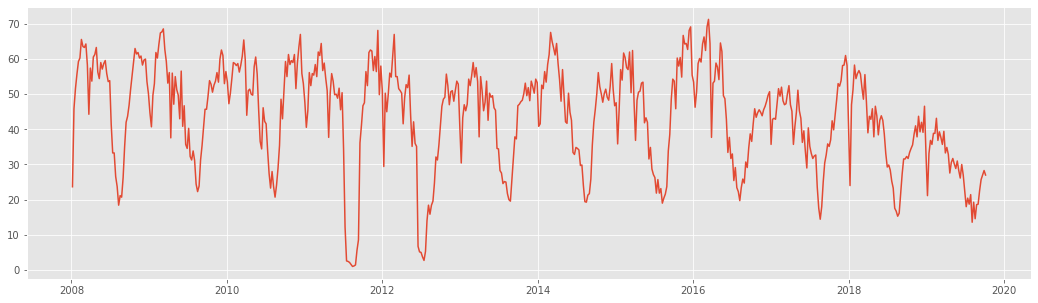

In [117]:
plt.plot(weekly)

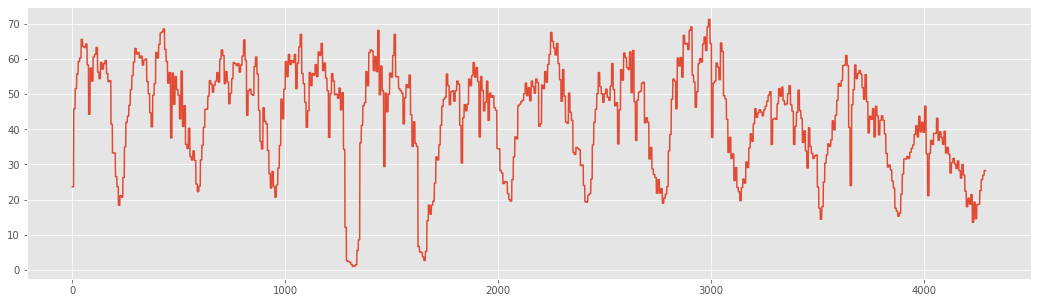

In [118]:
plt.plot(weekly_to_subs)

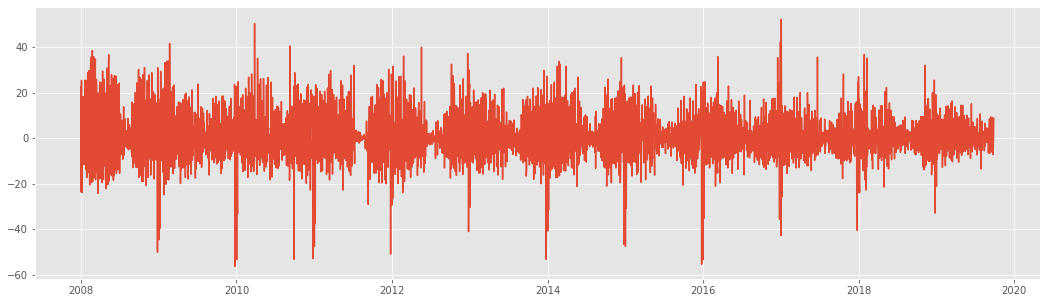

In [119]:
plt.plot(differences)

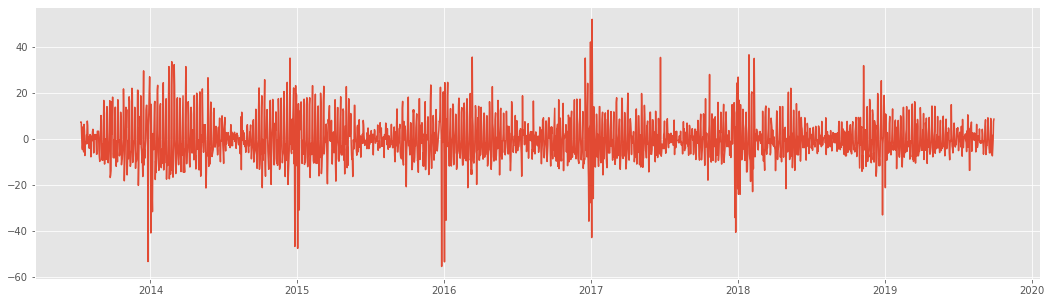

In [120]:
plt.plot(differences[2019:])

In [121]:
weekly.describe()

count    614.000000
mean      43.642082
std       14.518516
min        1.000000
25%       33.535714
50%       46.714286
75%       54.535714
max       71.285714
Name: units_ordered, dtype: float64

In [122]:
differences.describe()

count    4.290000e+03
mean    -1.026892e-16
std      1.078982e+01
min     -5.642857e+01
25%     -6.714286e+00
50%     -1.142857e+00
75%      5.714286e+00
max      5.214286e+01
Name: units_ordered, dtype: float64

# 3) Model selection<a id='a3'></a>

So, examining again our recolection of mean MSE for all our models, we find that:

In [123]:
mse_all_models

{'general_mean': 237.60425215725877,
 'weekday_means': 182.427876585366,
 'Naîve_guess': 78.87142857142858,
 'Holt-Winters': 56.475005729459234,
 'ARIMA': 64.3537474957731,
 'SARIMA': 53.07149228869635,
 'Prophet': 62.69486959340695,
 'Random Forest': 49.0,
 'MLR': 57.0,
 'KNN': 57.0}

We want also to plot the distributions of errors for all our series, and also the weekday-wise Naîve guess we have set as benchmark:

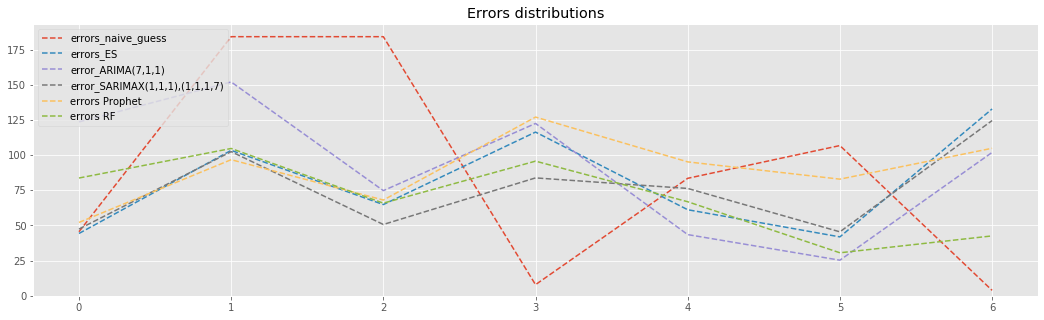

In [124]:
fig, ax =plt.subplots()

ax.plot(mean_mse_series_naive, '--')
ax.plot(mean_mse_series_ES, '--')
ax.plot(b_mean_mse_series_ARIMA, '--')
ax.plot(b_mean_mse_series_SARIMAX, '--')
ax.plot(mean_mse_series_prophet, '--')
ax.plot(mean_mse_series_RF, '--')

ax.set_ylim(bottom=0)

plt.legend(['errors_naive_guess','errors_ES','error_ARIMA(7,1,1)', 'error_SARIMAX(1,1,1),(1,1,1,7)', 'errors Prophet', 'errors RF'])
plt.title('Errors distributions');

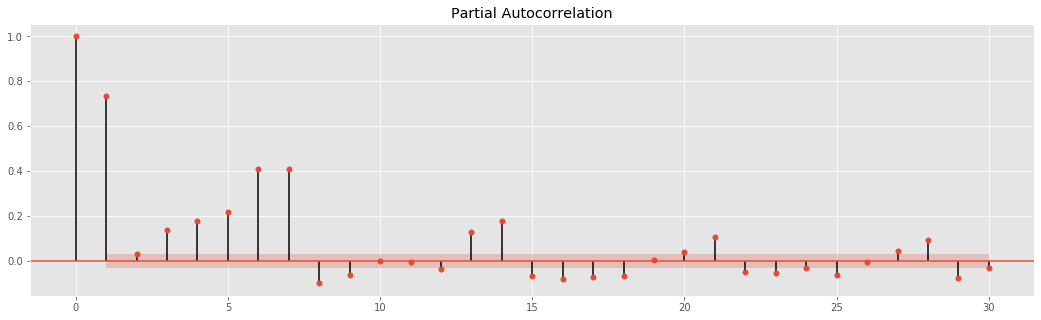

In [125]:
plot_pacf(series, lags = 30);

As we can see, not only are the methods more accurate in mean, but more stable when comparing the error commited, than our benchmark model.

Remarkably, even though the mean MSE is halfway in value that of the Naîve guess, the distribution of errors for the Random Forest is more uniform than it is for the Naive Guess.

We can also observe how the Random Forest yields it lowest error on the first prediction (in the same range as the error commited by the time series models) and how the mean error commited grows up to the 4th lag, from which it starts its decline.

This is congruent with the behaviour of the series and the model itself. Given that the lag 1 and 7 carry the most of the weight of the autocorrelations, and lag 1 is not available for prediction from the second predicted value on, a lot of information is lost, and those models will in return have a poorer performance. They all will lay in their respective 7th lags (meaning 6th, 5th, ... lags of the overall series), until, for the 7th model, its lag 7 coefficient is lag 1 from our first model.

To this phenomenom another one comes to add its effect: the 2nd, 3rd and 4th lags are the ones that present the least values of correlation. So, in turn, predictions based mainly on those lags (because of the 7 lag relationship the models are laying on), which are the ones that predict 3 and 4 days ahead, also should, because of this reason, the worst behaviour.
    
As it is shown above, Prophet and SARIMA keep their errors under control when compared with the rest of the models.

**Predicting with SARIMA and Prophet:**

We are now going to use the SARIMA and Prophet models to the end of our dataseries, and check their behaviour during the last two weeks of the month of September:

In [126]:
test = series['09-15-2019':'09-30-2019']
train = series['09-16-2018':'09-15-2019']

series_to_plot = series['09-16-2018':'09-30-2019']

order = (6,1,0)
seas_order = (2,1,1,7)

SAR_summ, SAR_pred, SAR_res, SAR_aic, SAR_error, SAR_fitted = eval_sarimax_model(order, seas_order, train , test)

prophet_fitted_val, prophet_series, prophet_predictions, res_prophet, squared_dif_series, mse_prophet = eval_prophet(train, test);

SAR_series = series - SAR_res -SAR_fitted

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [127]:
p_f_v = pd.Series(prophet_fitted_val.values, index=prophet_series['ds'])
p_p = pd.Series(prophet_predictions['yhat'].values, index=prophet_predictions['ds'])
r_p = pd.Series(res_prophet.values, index=prophet_series['ds'])

In [128]:
p_f_v['05-01-2019']

25.723426583362503

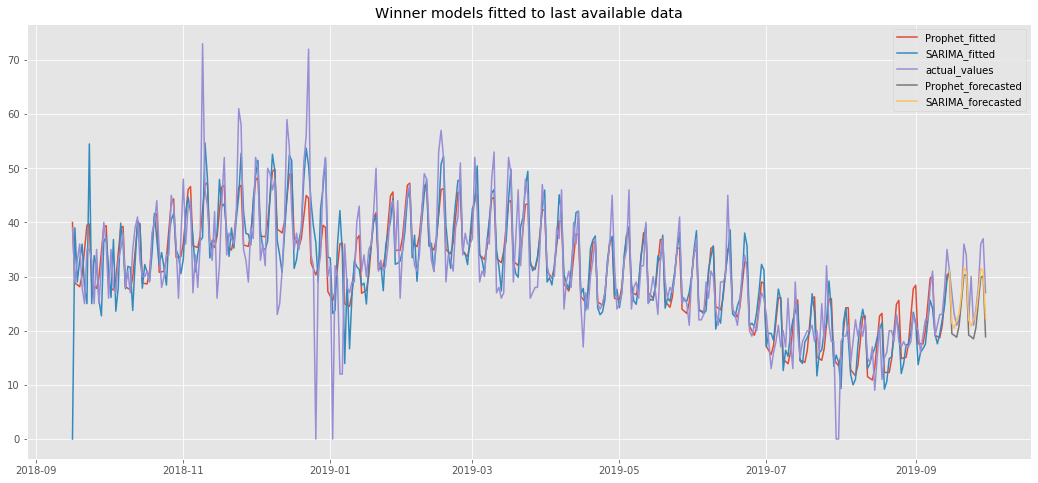

In [129]:
fig, ax = plt.subplots(figsize=(18,8))

ax.plot(p_f_v)
ax.plot(SAR_fitted)
ax.plot(series_to_plot)
ax.plot(p_p)
ax.plot(SAR_pred)
ax.legend(["Prophet_fitted", "SARIMA_fitted", "actual_values", "Prophet_forecasted", "SARIMA_forecasted"])
plt.title("Winner models fitted to last available data");

Taking a closer look to our forecasts:

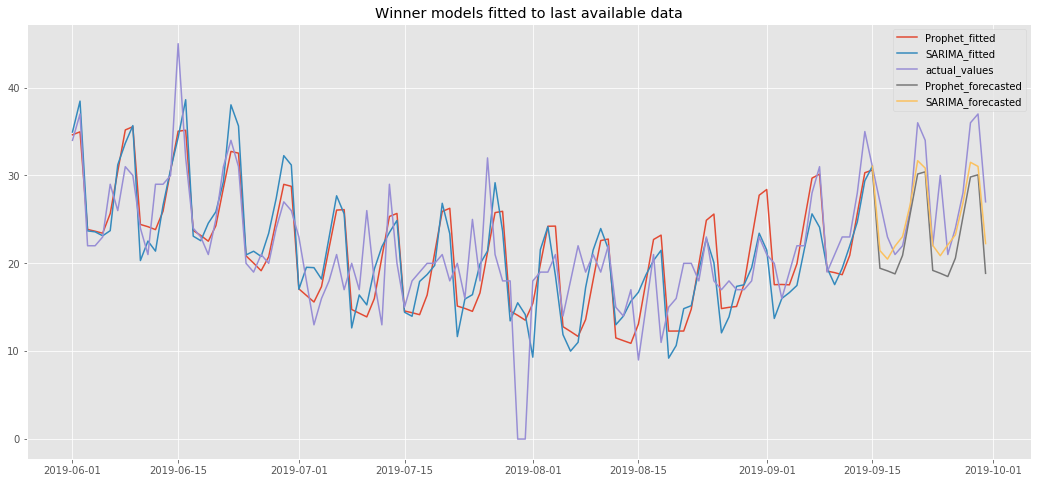

In [130]:
fig, ax = plt.subplots(figsize=(18,8))

ax.plot(p_f_v['06-01-2019':])
ax.plot(SAR_fitted['06-01-2019':])
ax.plot(series_to_plot['06-01-2019':])
ax.plot(p_p['06-01-2019':])
ax.plot(SAR_pred['06-01-2019':])
ax.legend(["Prophet_fitted", "SARIMA_fitted", "actual_values", "Prophet_forecasted", "SARIMA_forecasted"])
plt.title("Winner models fitted to last available data");

In [ ]:
plt.plot(r_p)
plt.plot(SAR_res)

plt.legend(["Prophet residuals", "SARIMA residuals"])
plt.title("Residuals of both models")

**Summing up:**

The best methods found were the SARIMA (specifically, a SARIMAX (6, 1, 0), $(2, 1, 1)_7$ model) and the Prophet.

This results should  surprise anybody: we are dealing with two specific time-series methods, very curated and tuned up to pick up all the information they can from a series.

We want to remark that the results presented in this notebook are, of course, in part due to chance, and that the reader could change them just by changing the seed or the number of trials, the number of days used for prediction or the interval to be predicted, or all these factors at once.

But, in general, results should the same general rules of behaviour that we have obtained here:

All time series methods should yield results better than the three benchmarks we decided to use for their analysis.

* In general, the general mean should be expected to yield the worst results.

* The mean by day of the week should yield the second worst result: better than the general mean, but worse than the naîve-guess method, when both are run a certain number of times, as the mean by weekday is not reflecting the moment in the year cycle that our data is in, so it cannot forecast accordingly.

* The time-series methods should all present a better behaviour than any of the benchmarks.

* Finally, the random forest, because of the reasons exposed above (for models to predict day d+2 and on, there is no lag 1 information directly at our disposal), should behave in the mid ground between the time-series methods and the best benchmark (in our case, the Naîve-guess).

We would like to mention here that it is not only the mean value of the error stimator used as reference that counts, but also its distribution: normally we will be willing to sacrifice a little bit of mean value in return of a great reduction in variance, for instance. We could have studied not only the mean value of our MSE's, but also their standard deviations and plot their boxplots for comparison. Doing it so should have given us useful insights.

Also, we would like to point out here also that Random Forest methods, as also other machine learning techniques and neuronal networks, are being exploited for time series analysis with great success. The reasons for this success is that they allow to easily integrate the endogenous correlations in the series with the external influence of other parameters. The reason our random forest model has not yielded results in the order of the best time series models is our lack of experience in its tuning, and the fact that we have fed it only with our series, and not with other information.

From the residual checks we have concluded that:

* The underlying distribution of this particular time series is not normally distributed. Undoubtedly, its residuals are not, and its variance is not constant. This might be a consequence of keeping extreme values when analyzing the outliers.

* The models that exploited well the information contained in the series were the ARIMA and SARIMA models. Both the Holt-Winters and the Prophet seem to have missed some correlations, specially the last one.

Now, in relation to the errors yielded, we want to transform the mean MSE obtained to something more easily understandable: 


In [131]:
mean_series = series.mean()

for key, element in mse_all_models.items():
    print("Mean equivalent percentage error equivalent to MSE:")
    print(key, element**(1/2)/mean_series)

Mean equivalent percentage error equivalent to MSE:
general_mean 0.3529749153918997
Mean equivalent percentage error equivalent to MSE:
weekday_means 0.30928748002372686
Mean equivalent percentage error equivalent to MSE:
Naîve_guess 0.20336517843823554
Mean equivalent percentage error equivalent to MSE:
Holt-Winters 0.17208573867669288
Mean equivalent percentage error equivalent to MSE:
ARIMA 0.18369767499958187
Mean equivalent percentage error equivalent to MSE:
SARIMA 0.16681972014696006
Mean equivalent percentage error equivalent to MSE:
Prophet 0.1813145849823821
Mean equivalent percentage error equivalent to MSE:
Random Forest 0.16029308173415588
Mean equivalent percentage error equivalent to MSE:
MLR 0.17288374688745697
Mean equivalent percentage error equivalent to MSE:
KNN 0.17288374688745697


Here we have transformed the mean MSE obtained for each method to an equivalent percentage value error.

As the MSE is the mean squared error, taking its root square gives us an indicative value of the mean error commited. Comparing this error to the mean value of the series, we get a rough impression of the mean error in which each model incurs.

Notice that this is not equivalent to the mean absolute percentage error.

We can see that, currently, the mean error commmited by our best models is up to 15,3%. We would need a finer tunning of the models, adding external information and, perhaps, a finer filtering of the data series to increase the accuracy of our predictions.

In terms of the finer filtering, we want to remark that perhaps we kept more outliers than we should, making the series less foreseeable/ less forecastable.

# 4) Conclusions<a id='a4'></a>

Our main conclusions so far would be:
    
1) Best models for prediction: SARIMA (using the SARIMAX function) and Prophet.

    
2) Mean error commited: MSE of about 45, or, in terms of the series, mean errors in the range of the 15% are being commited.


3) For this reason, some refinements should be introduced in order to lower this error, as, for instance:


* Using more, different models: for instance, Multivarient Random Forest, the Multiple Linear Regression method, or Neuronal Networks.


* A finer tunning of the models could, perhaps, result in an improvement in their mean error, studying, for instance, the appropriate data range for its fitting.


* Adding external information should lead to better predictions and less error. In this regard, we had collected a football matches calendar and a festivities and holidays calendar, which we pretended to feed to our models.


* Our series could be being currently difficult to forecast because we decided to set a high threshold when considering           outliers, perhaps removing more of those outliers would, in return, lower the error commited by our models.


* The series presents both weekly and yearly seasonality. Along this script we have only exploited the more important of those two: the weekly seasonality. Using both should return us better models. There are several ways of doing it so:


    - Using the diff(7) or dif(365) (preferably) series to feed our models, then reconstruct the original using the cumsum() function.

    - Divide the series in a weekly component, and a differences to the weekly mean part (by, for instance, aggregating the data by mean and substracting it to the series), and then forecasting each series appart, and adding up the results of the two forecasts.


4) We are willing to explore some of the ways of improvement aforementioned to better exploit the information in the series and return better forecasts.